# Projet de conception et de programmation.

Ceci est le notebook regroupant les différentes implémentations dans le cadre du projet de conception et de programmation intitulé : Investigating feature selection techniques to improve data mining tasks.

Il est constitué de cinq parties : 
1. Une introduction au data mining.
1. Le premier chapitre sur l'explication d'une thoerie issue du data mining.
1. Le deuxième chapitre sur les algorithmes de cette thoerie
1. Le troisème chapitre d'application des algorithmes sur des dataset.
1. Une conclusion.
Et une bibliographie.

# Importations.

Outils.

In [1]:
from __future__ import unicode_literals # lettre grec

import pandas as pd # DataFrame, ...
import numpy as np # array, ...
from fractions import Fraction
from itertools import combinations # combinaison
from functools import reduce
from collections import Counter
import copy
import math

# visualistion
import seaborn as sns
from matplotlib import pyplot as plt

# imbalanced learn
# conda install -c conda-forge imbalanced-learn
# https://imbalanced-learn.org/stable/introduction.html
# from imblearn.over_sampling import RandomOverSampler

Sklearn.

In [2]:
# sklearn
## preprocessing
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

## Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

Fuzzy sklearn.

In [3]:
# fuzzy sklearn
# pip install git+https://github.com/oulenz/fuzzy-rough-learn.git
from frlearn.classifiers import FRNN
from frlearn.base import probabilities_from_scores, select_class
from frlearn.feature_preprocessors import FRFS, RangeNormaliser

# Variable globale.

In [4]:
OUT_IMG = "./out/img/"
RANDOM_STATE = 42


# Fonctions.

## Outils.

### Fonction différence entre deux listes

In [5]:
def diff_list(list1, list2):
	"""
	Renvoie la différence entre deux listes.
	@param list1 une première liste.
	@param list2 une deuxième liste.
	@return les éléments présents dans list1 mais pas dans list2.
	"""
	set_list2 = set(list2)
	diff = [x for x in list1 if x not in set_list2]
	return diff

#### Test.

In [6]:
list1 = [1, 2, 3, 4, 5]
list2 = [1, 2, 4]
diff_list(list1, list2)

[3, 5]

Les éléments 3 et 5 sont présent dans la list1 mais pas dans la list2.

In [7]:
list1 = [1, 2, 4]
list2 = [1, 2, 3, 4, 5]
diff_list(list1, list2)

[]

Tous les éléments dans la list1 sont présent dans la list2. La fonction renvoie une liste vide.

### Fonction combinaison des attributs dans un système de décision.

In [8]:
def combinaisons(DS, d):
	"""
	Renvoie la liste des combinaisons des attributs du dataframe en 
	paramètre.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return list_combinaisons La liste des combinaisons des attributs.
	"""
	list_combinaisons = list()
	C = list(DS.columns)
	C.remove(d)
	for n in range(len(C) + 1):
		list_combinaisons += list(combinations(C, n))
	list_combinaisons.remove(())
	return list_combinaisons

#### Test.

In [9]:
# création d'un dataframe
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}
df = pd.DataFrame(data)

# initialisation de l'index
df.set_index("Patients", inplace=True)

# affichage des attributs
df.columns[:-1]

Index(['Headache', 'Muscle-pain', 'Temperature'], dtype='object')

La liste des combinaisons avec les attributs ci-dessus.

In [10]:
combinaisons(df, "Flu")

[('Headache',),
 ('Muscle-pain',),
 ('Temperature',),
 ('Headache', 'Muscle-pain'),
 ('Headache', 'Temperature'),
 ('Muscle-pain', 'Temperature'),
 ('Headache', 'Muscle-pain', 'Temperature')]

### *Cosine similary*.

Lien: https://stackoverflow.com/questions/14720324/compute-the-similarity-between-two-lists

In [11]:
def counter_cosine_similarity(liste1, liste2):
    """
    Calcul la ""cosine similarity" entre deux listes.
    @param liste1: la première liste.
    @param liste2: la deuxième liste.
    """
    c1 = Counter(liste1)
    c2 = Counter(liste2)
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

## *Data visualisation*.

Répartition des objets en fonction des classes.

In [12]:
def my_pie(df, class_name, titre_img):
	"""
	Affiche la repartition des donnees en fonctions des classes.
	@param df: le Dataframe des donnees.
	@param class_name: le nom de la classe.
	@param titre_img: le titre de l'image.
	"""
	plt.figure(figsize=(5,5))
	labels = np.unique(df[class_name].values)
	tmp = [df[df[class_name] == x] for x in labels]
	data = [len(x) for x in tmp]
	fig = plt.pie(x = data, labels = labels, autopct = '%.0f%%')
	plt.title("Répartition des objets par classes")
	plt.savefig(f"{OUT_IMG}{titre_img}.png", bbox_inches='tight')
	plt.show()

Boxplot

In [13]:
def my_boxplot(df, attributs_plot, figsize):
	"""
	Affiche la distribution des donnees par attributs.
	@param df: le Dataframe.
	@param attributs_plot: la liste des attributs a afficher.
	@param figsize: la taille de la figure.
	"""
	for attribut in [x for x in df.columns if x in attributs_plot]:
		plt.figure(figsize=figsize)
		sns.boxplot(x = attribut, data = df, palette = ['orange'])
		plt.title(f"boxplot {attribut}")
		plt.xlabel(f"{attribut}")
		plt.savefig(f"{OUT_IMG}boxplot/{attribut}.png", bbox_inches='tight')
		plt.show()

Matrice de correlation.

In [14]:
def my_correlation_matrix(df):
	"""
	Affiche la matrice de correlation.
	@param df: le Dataframe.
	"""
	plt.figure(figsize=(15,8))
	corr_matrix = df.corr()
	sns.heatmap(corr_matrix, annot=True)
	plt.title("Matrice de corrélation")
	plt.savefig(f"{OUT_IMG}matrice_correlation.png", bbox_inches='tight')
	plt.show()

Pairplot.

In [15]:
def my_pairplot(df, class_name):
	"""
	Affiche les relations entres les pairs d'attributs.
	@param df: le Dataframe.
	@param class_name: le nom de la classe.
	"""
	labels = np.unique(df[class_name].values)
	num_labels = len(labels)
	if num_labels <= 10:
		sns.pairplot(df, hue=class_name, corner = True, palette = sns.color_palette(n_colors = num_labels), height=4)
		plt.suptitle("Pair Plot", size = 40)
		plt.savefig(f"{OUT_IMG}pairplot.png", bbox_inches='tight')
		plt.show()
	else :
		print("Pas assez de couleurs")

Histplot.

In [16]:
def my_histplot(df, attributs_plot, class_name, figsize):
	"""
	Affiche l'histogramme des attribus.
	@param df: le Dataframe.
	@param attributs_plot: la liste de attributs a afficher.
	@param class_name: le nom de la classe.
	@param figsize: la taille de la figure.
	"""
	labels = np.unique(df[class_name].values)
	num_labels = len(labels)
	if num_labels <= 10:
		for attribut in attributs_plot:
			plt.figure(figsize=figsize)
			sns.histplot(x = attribut, data = df, kde = True, palette = sns.color_palette(n_colors = num_labels), hue = class_name)
			plt.title(f"Histogramme de {attribut}")
			plt.savefig(f"{OUT_IMG}histplot/{attribut}.png", bbox_inches='tight')
			plt.show()
	else :
		print("Pas assez de couleurs")

## Evaluation des modèles de classification.

Rapport de classification.

In [17]:
def my_classification_report(model_name, pred, y_test):
	"""
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param pred: le tableau de prediction.
	@param y_test: les classes du test set.
	"""
	print("Rapport de classification pour {}".format(model_name))
	print(classification_report(y_true=y_test, y_pred=pred))

Matrice de confusion.

In [18]:
def plot_confusion_matrix(title, model_name, df, class_name, pred, y_test, figsize):
    """
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param df: le Dataframe.
	@param class_name: le nom de la classe.
	@param pred: le tableau de prediction.
	@param y_test: les classes du test set.
	@param figsize: la taille de la figure.
	"""
    
    labels = np.unique(df[class_name].values)
    conf_matrix = confusion_matrix(y_test, pred, labels=labels)
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=labels)
    df_conf_matrix["index"] = labels
    df_conf_matrix = df_conf_matrix.set_index("index")

    plt.figure(figsize=figsize)
    sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Matrice de confusion pour {model_name}")
    plt.savefig(f"{OUT_IMG}confusion_matrix/{model_name}_{title}.png", bbox_inches='tight')
    plt.show()

Courbe d'apprentissage.

In [19]:
def my_learning_curve(title, model_name, model, x_train, y_train, figsize):
    """
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param model: le modele de classification.
    @param x_train: les donnees du train set.
    @param y_train: les classes du train set.
    @param figsize: la taille de la figure.
	"""

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model, X=x_train, y=y_train, 
        train_sizes=np.linspace(0.1, 1.0, 4),
        n_jobs=10, verbose=0, random_state=42)

    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    #
    # Plot the learning curve
    #
    plt.figure(figsize=figsize)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title("Learning curve pour {}".format(model_name))
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.savefig(f"{OUT_IMG}learning_curve/{model_name}_{title}.png", bbox_inches='tight')
    plt.show()

*Roc curve*.

In [20]:
def plot_roc_curve(title, model_name, model_fit, X_test, y_test, figsize): 
	"""
	Affiche le rapport de classification.
	@param model_name: le nom du modele.
	@param model_fit: le modele de classification.
	@param X_test: les donnees du test set.
	@param y_test: les classes du test set.
	@param figsize: la taille de la figure.
	"""

	probs = model_fit.predict_proba(X_test)  
	probs = probs[:, 1]
	fper, tper, thresholds = roc_curve(y_test, probs) 

	plt.figure(figsize=figsize)
	plt.plot(fper, tper, color='orange', label='ROC')
	plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title("ROC curve pour {}".format(model_name))
	plt.savefig(f"{OUT_IMG}roc_curve/{model_name}_{title}.png", bbox_inches='tight')
	plt.legend()
	plt.show()

Evaluation global.

In [21]:
def evaluation(title, liste_prediction, df, class_name, X_train, X_test, y_train, y_test):
	"""
	Affiche le rapport de classification.
	@param liste_prediction: la liste contenant les modeles.
	@param df: le Dataframe.
	@param class_name: le nom de la classe.
	@param X_train: les donnees du train set.
	@param X_test: les donnees du test set.
	@param y_train: les classes du train set.
	@param y_test: les classes du test set.
	"""
	for nom, model_fit, y_pred_test in liste_prediction:
		figsize = (4,3)
		my_classification_report(nom, y_pred_test, y_test)

		plot_confusion_matrix(title, nom, df, class_name, y_pred_test, y_test, figsize)

		my_learning_curve(title, nom, model_fit, X_train, y_train, figsize)

		plot_roc_curve(title, nom, model_fit, X_test, y_test, figsize)

## Entrainement.

In [22]:
def entrainement(classifiers, X_train, y_train, X_test):
	"""
	Entraine les modeles et predits les classes.
	@param classifiers: dictionnaire contenant le nom et un modele de classifications.
	@param X_train: les donnees du train set.
	@param X_test: les donnees du test set.
	@pamam y_train: les classes du train set.
	@return liste_predictions: une liste contenant le nom, le modele entraine et les predictions.
	"""
	liste_predictions = []

	for nom, model in classifiers.items():
		print(nom)

		# entrainement des modeles.
		print("fitting...", end="")
		model_fit = model.fit(X_train, y_train)
		print("Done")
		
		# prediction des classes du test set.
		print("predicting labels...", end="")
		y_pred_test = model_fit.predict(X_test)
		print("Done")

		liste_predictions.append((nom, copy.deepcopy(model_fit), y_pred_test))
		print("")
	
	return liste_predictions

## *Preprocessing*.

### Encodage.

Encodage attributs.

In [23]:
def encodage_attributs(df, attributs):
	oe = OrdinalEncoder()
	df[attributs] = oe.fit_transform(df[attributs])

	return df

Encodage classes.

In [24]:
def encodage_classe(df, class_name):
	le = LabelEncoder()
	df[class_name] = le.fit_transform(df[class_name])
	
	return df

### Normalisation.

Normalisation attributs.

In [25]:
def normalisation_attributs(df, attributs):
	mm = MinMaxScaler()
	df[attributs] = mm.fit_transform(df[attributs])
	return df

Normalisation classes.

In [26]:
def normalisation_classe(df, class_name):
	df[class_name] = df[class_name].apply(lambda x: x-1)
	return df

### Discretisation.

In [27]:
def discretisation(df):
	df["age"] = df["age"].apply(lambda x: "Young" if x < 40 else "Mid" if x <= 60 else "Old")
	df["blood pressure"] = df["blood pressure"].apply(lambda x: "Normal" if x < 139 else "Abnormal")
	df["cholestoral"] = df["cholestoral"].apply(lambda x: "Abnormal" if x < 150 else "Normal" if x <= 250 else "Abnormal")
	df["heart rate max"] = df["heart rate max"].apply(lambda x: "Low" if x < 60 else "Normal" if x <= 100 else "Hight")

	return df

### Suppression valeurs aberrantes.

In [28]:
def remove_outliers(df):
	df = df[df["chest pain type"] > 0.5]
	df = df[df["vessels"] < 2.5] 

	return df 

## Decoupage du dataset.

In [29]:
def decoupage(df, attributs, class_name):
	X = df[attributs]
	y = df[class_name]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
	print("X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

	return X_train.values, X_test.values, y_train.values, y_test.values

# Chapitre 3: Implémentation et tests.

## Jeu de test.

In [30]:
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}

df = pd.DataFrame(data)
df.set_index("Patients", inplace=True)
df

,Headache,Muscle-pain,Temperature,Flu
Patients,,,,
o1,Yes,Yes,very high,Yes
o2,Yes,No,high,Yes
o3,Yes,No,high,No
o4,No,Yes,normal,No
o5,No,Yes,high,Yes
o6,No,Yes,very high,Yes


In [31]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 2, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 1],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,2,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,1,1


## *Indiscernibility Relation*.

### Implémentation.

In [32]:
def IND(DS, d, C):
	"""
	Calcule la Indiscernibility Relation pour un attribut.
	
	@param DS le système de décision.
	@param d la décision.
	@param C La liste des attributs.
	
	@return ind la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(C)

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets possèdants les même valeurs pour l'attribut "Headache".

In [33]:
ind = IND(df, "Flu", ["Headache"])
ind

C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:


[['o1', 'o2', 'o3'], ['o4', 'o5', 'o6']]

On regroupe les objets possèdants les même valeurs pour l'ensemble d'attribut {"Headache", "Muscle-pain"}.

In [34]:
ind2 = IND(df, "Flu", ["Headache", "Muscle-pain"])
ind2

[['o1'], ['o2', 'o3'], ['o4', 'o5', 'o6']]

### Implémentation 2.

In [35]:
def IND_C(DS, d):
	"""
	Calcule la Indiscernibility Relation pour tous les
	attributs du système de décision.
	
	@param DS le système de décision.
	@param d la décision.
	
	@return ind_c la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(list(IS.columns))

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets ayant les même valeurs pour tous les attributs.

In [36]:
ind_c = IND_C(df, "Flu")
ind_c

[['o1'], ['o2', 'o3'], ['o4'], ['o5'], ['o6']]

In [37]:
ind_c2 = IND_C(df2, "e")
ind_c2

[['x1'], ['x2', 'x8'], ['x3', 'x6'], ['x4'], ['x5'], ['x7']]

### Fonction groupe_ind_c_obj

### Implémentation.

In [38]:
def groupe_ind_c_obj(ind_c, obj):
	"""
	Renvoie le groupe indiscernable de l'objet obj sans ce dernier.

	@param ind_c la liste des objets indiscernable.
	@param obj l'index d'un objet.

	@return le groupe indiscernable de l'objet.
	"""
	for g in ind_c:
		for obj2 in g:
			if obj == obj2:
				copy_g = g.copy()
				copy_g.remove(obj)
				return copy_g
	return []

### Test.

On affiche les objets qui sont dans le même groupe indiscernable. Si le retour est vide c'est que l'objet ne possède est seul dasn son groupe, i.e il ne n'existe pas d'objet indiscernable à cette objet.

On cherche le groupe indiscernable de o3 qui est [o2, o3], la fonction nous renvoie uniquement [o3].

In [39]:
groupe_ind_c_obj(ind_c, "o3")

['o2']

On cherche le groupe indiscernable de o1 qui est [o1], la fonction nous renvoie une liste vide.

In [40]:
groupe_ind_c_obj(ind_c, "o1")

[]

On cherche le groupe indiscernable de x8 qui est [x2, x8], la fonction nous renvoie uniquement [x8].

In [41]:
groupe_ind_c_obj(ind_c2, "x8")

['x2']

## *B-lower approximation*.

### Implémentation.

In [42]:
def b_lower(DS, ind_c, d, d_value):
    """
    Renvoie la B-lower approximation.

    @param DS le système de décision.
    @param ind_c la liste des objets indiscernables.
    @param d le nom de la colonne de décision.
    @param d_value la valeur de décision.

    @return la B-lower approximation.
    """
    X = DS.groupby(d)
    Xi = None
    for name, groupe in X:
        if name == d_value:
            Xi = pd.DataFrame(groupe)

    if Xi is not None:
        CXi = []

        for index in Xi.index:
            # Nous regardons le groupe indiscernable de cet objet.
            idc_obj = groupe_ind_c_obj(ind_c, index)
            
            # Si aucun des objets indiscernables de cet objet n'a une décision différente.
            if not any(DS.at[index_obj2, d] != DS.at[index, d] for index_obj2 in idc_obj):
                CXi.append(index)
        CXi.sort()
        return CXi
    else:
        return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "No").

In [43]:
blower_yes = b_lower(df, ind_c, "Flu", "Yes")
blower_yes

['o1', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "Yes").

In [44]:
blower_no = b_lower(df, ind_c, "Flu", "No")
blower_no

['o4']

## *B-upper approximation*.

### Implémentation.

In [45]:
def b_upper(DS, ind_c, d, d_value):
    """
    Renvoie la B-upper approximation.

    @param DS le système de décision.
    @param ind_c la liste des objets indiscernables.
    @param d le nom de la colonne de décision.
    @param d_value la valeur de décision.

    @return la B-upper approximation.
    """
    X = DS.groupby(d)
    Xi = None
    for name, groupe in X:
        if name == d_value:
            Xi = pd.DataFrame(groupe)

    if Xi is not None:
        CXi = list(Xi.index)
        for index in Xi.index:
            # Nous regardons le groupe indiscernable de cet objet.
            idc_obj = groupe_ind_c_obj(ind_c, index)
            
            # Si il possède des objets indiscernables.
            list_add = [index_obj2 for index_obj2 in idc_obj
                        if DS.at[index_obj2, d] != DS.at[index, d]]
            CXi += list_add
        CXi.sort()
        return CXi
    else:
        return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [46]:
bupper_yes = b_upper(df, ind_c, "Flu", "Yes")
bupper_yes

['o1', 'o2', 'o3', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [47]:
bupper_no = b_upper(df, ind_c, "Flu", "No")
bupper_no

['o2', 'o3', 'o4']

## *B-boundary region*.

### Implémentation.

In [48]:
def b_boundary(DS, bupper, blower):
	"""
	Calcule la B-boundary region.

	@param DS le système de décision.
	@param bupper la B-upper approximation.
	@param blower la B-lower approximation.

	@return la différence entre les deux approximations.
	"""
	return diff_list(bupper, blower)

### Test.

bupper_yes = ['o1', 'o2', 'o3', 'o5', 'o6']

blower_yes = ['o1', 'o5', 'o6']

Les éléments qui sont présents dans bupper_yes mais pas dans blower_yes sont o2 et o3.

In [49]:
b_boundary(df, bupper_yes, blower_yes)

['o2', 'o3']

bupper_no = ['o2', 'o3', 'o4']

blower_no = ['o4']

Les éléments qui sont présents dans bupper_no mais pas dans blower_no sont o2 et o3.

In [50]:
b_boundary(df, bupper_no, blower_no)

['o2', 'o3']

## *Positive Region*.

### Implémentation.

In [51]:
def POS(DS, d, C):
	"""
	Calcul la Positive Region avec les C attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.
	@param C La liste des attributs.

	@return La Positive region des C attributs.
	"""
	attr = C.copy()
	attr.append(d)
	ds = DS[attr]
	ind = IND(ds, d, C)
	d_values = list(ds[d])
	d_values = [*set(d_values)]
	POS = []
	for d_value in d_values:
		POS += b_lower(ds, ind, d, d_value)
	POS.sort()
	return POS

### Test.

Nous calculons la POS pour toutes les combinaisons d'attributs.

In [52]:
for combi in combinaisons(df, "Flu"):
	liste_combi = list(combi)
	print("POS{{{}}} = {}".format(liste_combi, POS(df, "Flu", liste_combi)))

POS{['Headache']} = []
POS{['Muscle-pain']} = []
POS{['Temperature']} = ['o1', 'o4', 'o6']
POS{['Headache', 'Muscle-pain']} = ['o1']
POS{['Headache', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Headache', 'Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']


C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:


### Implémentation 2.

In [53]:
def POS_C(DS, d):
	"""
	Calcule la Positive Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Positive region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	POS_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		blower = b_lower(DS, ind_c, d, d_value)
		POS_C += blower
	POS_C.sort()
	return POS_C

### Test.

Nous calculons la POS pour tous les attributs.

In [54]:
POS_C(df, "Flu")

['o1', 'o4', 'o5', 'o6']

In [55]:
POS_C(df2, "e")

['x1', 'x3', 'x4', 'x5', 'x6', 'x7']

## *Negative Region*.

### Implémentation.

In [56]:
def NEG_C(DS, d):
	"""
	Calcule la Negative Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Negative region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	NEG_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		NEG_C += b_upper(DS, ind_c, d, d_value)
	NEG_C = [*set(NEG_C)]
	neg = diff_list(list(DS.index), NEG_C)
	neg.sort()
	return neg

### Test.

In [57]:
NEG_C(df, "Flu")

[]

In [58]:
NEG_C(df2, "e")

[]

## *Reduct*.

### Implémentation.

In [59]:
def reduct(DS, d):
	"""
	Renvoie toutes les réductions d'attributs possibles.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return reducts : La liste des réductions.
	"""
	reducts = []
	pos_c = POS_C(DS, d)
	C = list(DS.columns)
	C.remove(d)
	count_reduct_found = 0
	for combi in combinaisons(DS, d):
		liste_combi = list(combi)
		if liste_combi != C:
			pos = POS(DS, d, liste_combi)
			if pos == pos_c:
				print("reduc trouvé : {}".format(liste_combi))
				count_reduct_found += 1
				reducts.append(liste_combi)
	reducts.sort()

	if len(reducts)!= 0:
		# Affichage de la taille des reduuts trouvés.
		len_reducts = [len(x) for x in reducts]
		reduc_by_len = Counter(len_reducts)
		most_common = reduc_by_len.most_common()
		print("longueur - nombre reduct trouvés")
		for leng, count in most_common:
			print("{} - {}".format(leng, count))

		# On garde les plus petites reductions
		print("Selection des reducts minimaux...")
		min_len = min([len(x) for x in reducts])
		reducts = [x for x in reducts if len(x) == min_len]

	print("{} reducts trouvés".format(count_reduct_found))
	return reducts

### Test.

In [60]:
reducts = reduct(df, "Flu")
reducts

reduc trouvé : ['Headache', 'Temperature']
reduc trouvé : ['Muscle-pain', 'Temperature']
longueur - nombre reduct trouvés
2 - 2
Selection des reducts minimaux...
2 reducts trouvés


C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:


[['Headache', 'Temperature'], ['Muscle-pain', 'Temperature']]

In [61]:
# création d'un dataframe
data3 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 0, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 0],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df3 = pd.DataFrame(data3)
df3.set_index("x", inplace=True)
df3

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,0,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,0,1


In [62]:
reduct(df3, "e")

reduc trouvé : ['b', 'd']
reduc trouvé : ['c', 'd']
reduc trouvé : ['a', 'b', 'd']
reduc trouvé : ['a', 'c', 'd']
reduc trouvé : ['b', 'c', 'd']
longueur - nombre reduct trouvés
3 - 3
2 - 2
Selection des reducts minimaux...
5 reducts trouvés


C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a futur

[['b', 'd'], ['c', 'd']]

## *Core*.

### Implémentation.

In [63]:
def core(reducts):
	"""
	Calcul l'intersection de toutes les réductions.

	@param reducts la liste des réductions.

	@return le core du système de décision.
	"""
	return list(reduce(lambda i, j: i & j, (set(x) for x in reducts)))

### Test.

In [64]:
core(reducts)

['Temperature']

## Dépendance des attributs.

### Implémentation.

In [65]:
def dependance_attributs(DS, C, d):
	"""
	Calcul la dépendance des attributs.

	@param DS Le système de décision.
	@param C la liste des attributs.
	@param d la colonne de décision.

	@return la dépendance des attributs.
	"""
	ds = DS[C]
	if len(list(ds.columns)) == 1 and list(ds.columns)[0] == d:
		return 0
	ind_c = IND_C(ds, d)
	pos_c = POS_C(ds, d)
	# dep = Fraction(len(pos_c), len(ds.index))
	dep = float(len(pos_c)) / len(ds.index)
	return dep

In [66]:
def dependance_attributs2(DS, C, d):
    ds = DS[C]
    ind_c = IND_C(ds, d)
    pos_c = POS_C(ds, d)
    dep = sum(pos_c) / len(ds.index)
    return dep

## *QuickReduct*.

### Implémentation.

In [67]:
def quickReduct(DS, d):
	"""
	L'algorithme de quickReduct.

	@param DS Le système de décision.
	@param d la colonne de décision.

	@return une sous liste d'attributs.
	"""
	C = list(DS.columns)
	C.remove(d)
	print("C :", C)
	# calcul de lambda C.
	dep_C = dependance_attributs(DS, DS.columns, d)
	print("λC :", dep_C, "\n")
	R = []
	while True:
		T = R
		# calcul de lambda T.
		attr = T.copy() + [d]
		dep_T = dependance_attributs(DS, attr, d)
		print("λT({}) = {}".format(attr[:-1], dep_T))
		
		# calcul de C - R.
		C_R = diff_list(C, R)
		print("C_R", C_R)
		
		# parcours des attributs.
		changement_t = False
		for x in C_R:
			print("x :", x)
			# calcul de lambda RU{x}.
			attr2 = R.copy() + [x, d]
			dep_RUx = dependance_attributs(DS, attr2, d)
			print("λRUx({}) = {}".format(attr2[:-1], dep_RUx))
			
			# changement meilleur dépendance.
			if dep_RUx > dep_T:
				T = R.copy() + [x]
				print("changement R =", T)
				attr3 = T.copy() + [d]
				dep_T = dependance_attributs(DS, attr3, d)
				changement_t = True

		if not changement_t:
			return "error"
		
		R = T.copy()
		# calcul de lambda R.
		attr4 = R.copy() + [d]
		dep_R = dependance_attributs(DS, attr4, d)
		print("λR({}) = {}".format(attr4[:-1], dep_R))
		if dep_R == dep_C:
			return R

### Test.

In [68]:
quickReduct(df, "Flu")

C : ['Headache', 'Muscle-pain', 'Temperature']
λC : 0.6666666666666666 

λT([]) = 0
C_R ['Headache', 'Muscle-pain', 'Temperature']
x : Headache
λRUx(['Headache']) = 0.0
x : Muscle-pain
λRUx(['Muscle-pain']) = 0.0
x : Temperature
λRUx(['Temperature']) = 0.5
changement R = ['Temperature']
λR(['Temperature']) = 0.5
λT(['Temperature']) = 0.5
C_R ['Headache', 'Muscle-pain']
x : Headache
λRUx(['Temperature', 'Headache']) = 0.6666666666666666
changement R = ['Temperature', 'Headache']
x : Muscle-pain
λRUx(['Temperature', 'Muscle-pain']) = 0.6666666666666666
λR(['Temperature', 'Headache']) = 0.6666666666666666


C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a f

['Temperature', 'Headache']

2ème test.

In [69]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 0, 1, 2, 1],
	"b" : [2, 3, 3, 1, 2, 1, 2, 2],
	"c" : [4, 3, 1, 2, 0, 2, 1, 0],
	"d" : [0, 2, 3, 1, 1, 4, 3, 2],
	"e" : [1, 1, 3, 2, 2, 3, 2, 2],
	"X" : [1, 2, 2, 1, 1, 2, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e,X
x,,,,,,
x1,1,2,4,0,1,1
x2,0,3,3,2,1,2
x3,2,3,1,3,3,2
x4,1,1,2,1,2,1
x5,0,2,0,1,2,1
x6,1,1,2,4,3,2
x7,2,2,1,3,2,2
x8,1,2,0,2,2,1


In [70]:
quickReduct(df2, "X")

C : ['a', 'b', 'c', 'd', 'e']
λC : 1.0 

λT([]) = 0
C_R ['a', 'b', 'c', 'd', 'e']
x : a
λRUx(['a']) = 0.25
changement R = ['a']
x : b
λRUx(['b']) = 0.25
x : c
λRUx(['c']) = 0.75
changement R = ['c']
x : d
λRUx(['d']) = 0.75
x : e
λRUx(['e']) = 0.25
λR(['c']) = 0.75
λT(['c']) = 0.75
C_R ['a', 'b', 'd', 'e']
x : a
λRUx(['c', 'a']) = 0.75
x : b
λRUx(['c', 'b']) = 0.75
x : d
λRUx(['c', 'd']) = 1.0
changement R = ['c', 'd']
x : e
λRUx(['c', 'e']) = 1.0
λR(['c', 'd']) = 1.0


C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a f

['c', 'd']

# Chapitre 4:  Applications

## Chargement du dataset.

Lien : https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29

In [71]:
names = [
	"age", 
	"sex", 
	"chest pain type", 
	"blood pressure", 
	"cholestoral",
	"blood sugar",
	"electrocardiographic",
	"heart rate max",
	"angina",
	"oldpeak",
	"peak exercise",
	"vessels",
	"thal",
	"heart disease"
]

df = pd.read_csv("data/heart.dat", sep=" ", names=names)
df

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


### Informations sur les attributs: 
1. *age*
1. *sex*
1. *chest pain type (4 values)* = type de douleur thoracique
1. *resting blood pressure* = tension artérielle au repos
1. *serum cholestoral in mg/dl*
1. *fasting blood sugar > 120 mg/dl* = glycémie à jeun
1. *resting electrocardiographic results (values 0,1,2)* = résultats électrocardiographiques au repos
1. *maximum heart rate achieved* = fréquence cardiaque maximale atteinte
1. *exercise induced angina* = angine induite par l'effort
1. *oldpeak = ST depression induced by exercise relative to rest* = Dépression ST induite par l'exercice par rapport au repos
1. *the slope of the peak exercise ST segment* = la pente du segment ST d'effort maximal
1. *number of major vessels (0-3) colored by flourosop* = nombre de vaisseaux principaux (0-3) colorés par le fluorosop
1. *thal: 3 = normal; 6 = fixed defect; 7 = reversable defect*

### Types des attributs
Real: 1,4,5,8,10,12 <br>
Ordered:11, <br>
Binary: 2,6,9 <br>
Nominal:7,3,13

### Variables à prédire
Absence (1) or presence (2) of heart disease

### Découpage des attributs et de la classe.

In [72]:
attributs = df.columns.to_list()
attributs.remove("heart disease")
class_name = "heart disease"
"attributs", attributs, "classe", class_name

('attributs',
 ['age',
  'sex',
  'chest pain type',
  'blood pressure',
  'cholestoral',
  'blood sugar',
  'electrocardiographic',
  'heart rate max',
  'angina',
  'oldpeak',
  'peak exercise',
  'vessels',
  'thal'],
 'classe',
 'heart disease')

## Exploration des données.

#### Statistiques.

In [73]:
pd.set_option("display.float", "{:.2f}".format)
dfx = df.drop(columns=[class_name])
dfx.describe()

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal
count,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00
mean,54.43,0.68,3.17,131.34,249.66,0.15,1.02,149.68,0.33,1.05,1.59,0.67,4.70
std,9.11,0.47,0.95,17.86,51.69,0.36,1.00,23.17,0.47,1.15,0.61,0.94,1.94
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00
25%,48.00,0.00,3.00,120.00,213.00,0.00,0.00,133.00,0.00,0.00,1.00,0.00,3.00
50%,55.00,1.00,3.00,130.00,245.00,0.00,2.00,153.50,0.00,0.80,2.00,0.00,3.00
75%,61.00,1.00,4.00,140.00,280.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00


#### Valeurs manquantes et valeurs nulles

In [74]:
df.isna().sum()

age                     0
sex                     0
chest pain type         0
blood pressure          0
cholestoral             0
blood sugar             0
electrocardiographic    0
heart rate max          0
angina                  0
oldpeak                 0
peak exercise           0
vessels                 0
thal                    0
heart disease           0
dtype: int64

In [75]:
df.isnull().sum()

age                     0
sex                     0
chest pain type         0
blood pressure          0
cholestoral             0
blood sugar             0
electrocardiographic    0
heart rate max          0
angina                  0
oldpeak                 0
peak exercise           0
vessels                 0
thal                    0
heart disease           0
dtype: int64

#### Discretisation.
Pour pouvoir appliquer les algorithmes du *Rough Set*, nous devons discrétiser nos données.
Voici comment nous allons procéder:

|      Attribut      |    Interval    | Discretisation |
|:------------------:|:--------------:|:--------------:|
|         age        |   [20 - 40)    |     Young      |
|                    |   [40 - 60)    |      Mid       |
|                    |   [60 - 80)    |      Old       |
|   Blood Pressure   |   [90 - 139]   |     Normal     |
|                    |   > 140        |    Abnormal    |
|     Cholestoral    |   [150 - 250]  |     Normal     |
|                    | < 150 or > 250 |    Abnormal    |
| Maximum heart rate |      < 60      |       Low      |
|                    |   [60 - 100]   |     Normal     |
|                    |      > 100     |     Hight      |

In [76]:
df = discretisation(df)
df

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,Old,1.00,4.00,Normal,Abnormal,0.00,2.00,Hight,0.00,2.40,2.00,3.00,3.00,2
1,Old,0.00,3.00,Normal,Abnormal,0.00,2.00,Hight,0.00,1.60,2.00,0.00,7.00,1
2,Mid,1.00,2.00,Normal,Abnormal,0.00,0.00,Hight,0.00,0.30,1.00,0.00,7.00,2
3,Old,1.00,4.00,Normal,Abnormal,0.00,0.00,Hight,1.00,0.20,2.00,1.00,7.00,1
4,Old,0.00,2.00,Normal,Abnormal,0.00,2.00,Hight,1.00,0.20,1.00,1.00,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Mid,1.00,3.00,Abnormal,Normal,1.00,0.00,Hight,0.00,0.50,1.00,0.00,7.00,1
266,Mid,1.00,2.00,Normal,Abnormal,0.00,0.00,Hight,0.00,0.00,1.00,0.00,7.00,1
267,Mid,0.00,2.00,Abnormal,Abnormal,0.00,2.00,Hight,0.00,1.30,2.00,0.00,3.00,1
268,Mid,1.00,4.00,Abnormal,Normal,0.00,0.00,Hight,0.00,0.40,2.00,0.00,6.00,1


## *Data visualization*.

In [77]:
df_prepro = copy.deepcopy(df)

Encodage.

In [78]:
df_prepro = encodage_attributs(df_prepro, attributs)
df_prepro

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,1.00,1.00,3.00,1.00,0.00,0.00,2.00,0.00,0.00,23.00,1.00,3.00,0.00,2
1,1.00,0.00,2.00,1.00,0.00,0.00,2.00,0.00,0.00,16.00,1.00,0.00,2.00,1
2,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,2.00,2
3,1.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,1.00,2.00,1
4,1.00,0.00,1.00,1.00,0.00,0.00,2.00,0.00,1.00,2.00,0.00,1.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.00,1.00,2.00,0.00,1.00,1.00,0.00,0.00,0.00,5.00,0.00,0.00,2.00,1
266,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1
267,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,13.00,1.00,0.00,0.00,1
268,0.00,1.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00,1.00,0.00,1.00,1


Nombre d'instances par classes.

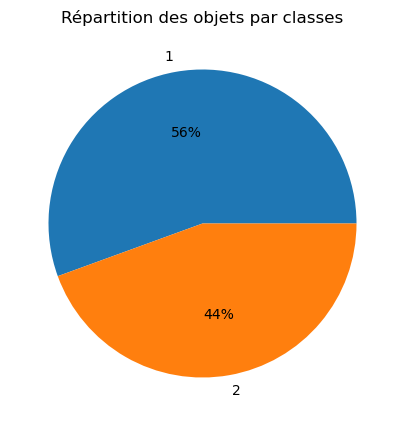

In [79]:
my_pie(df_prepro, class_name, "pie")

Les données sont équitablement réparties dans les classes, nous n'avons pas besoin de les équilibrer.

Matrice de corrélation.

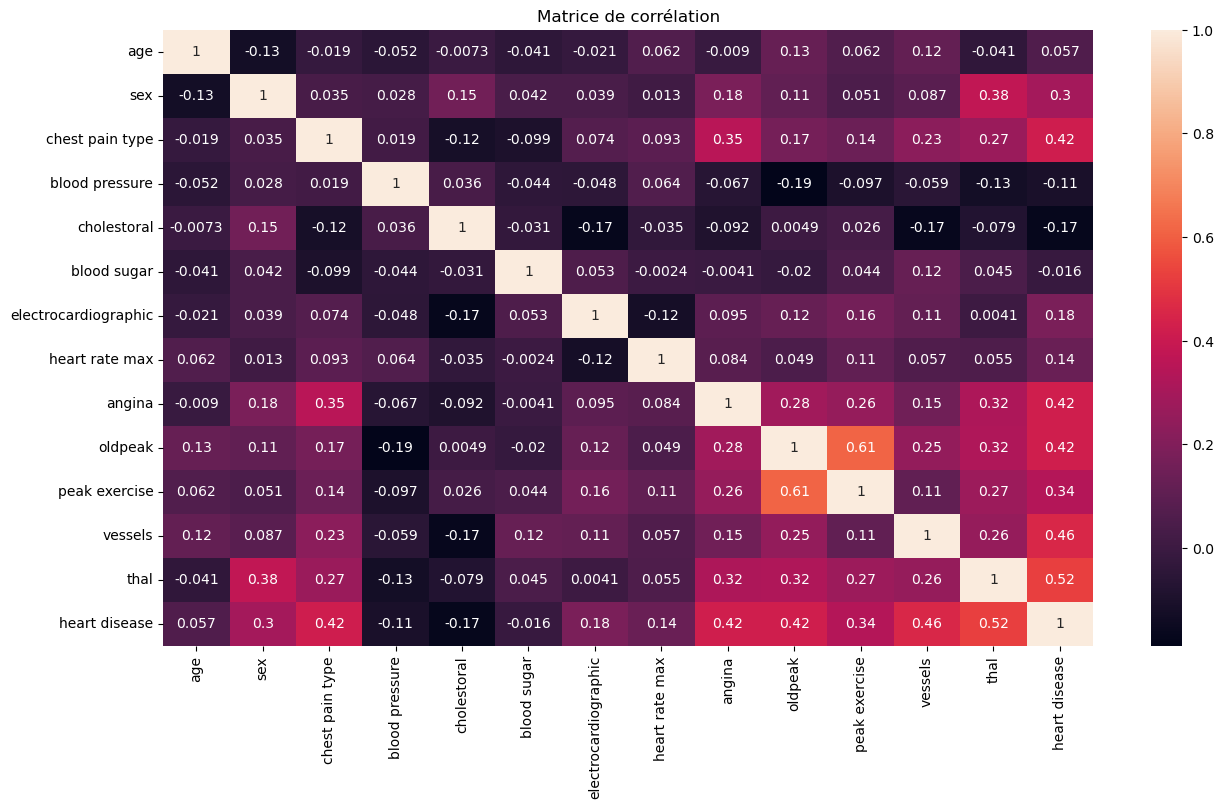

In [80]:
my_correlation_matrix(df_prepro)

Il y a une corrélation moyenne entre "heart disease" et "chest pain type", ainsi que "angina", "oldpeak", "vessels" et "thal".

Boxplot.

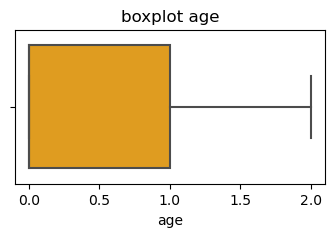

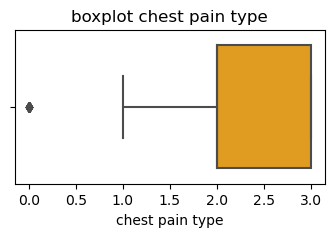

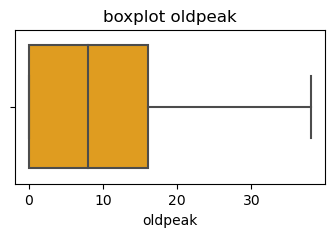

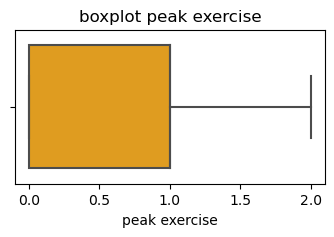

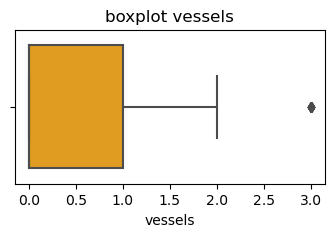

In [81]:
attributs_utils = [
	"age",
	"chest pain type",
	"oldpeak",
	"peak exercise",
	"vessels"
]
figsize = (4,2)
my_boxplot(df_prepro, attributs_utils, figsize)

Il faut supprimer les valeurs aberrantes dans *vessels* et *chest pain type*

Histplot.

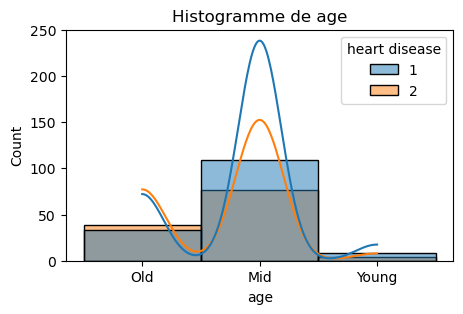

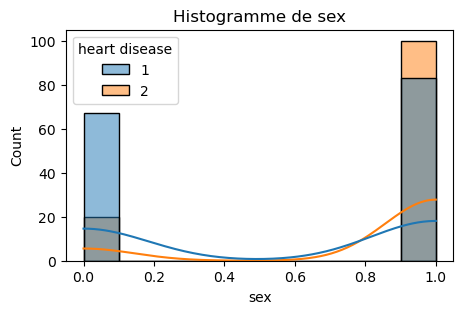

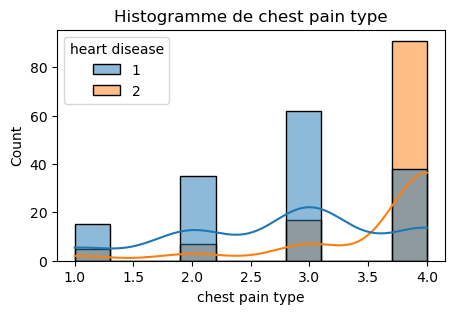

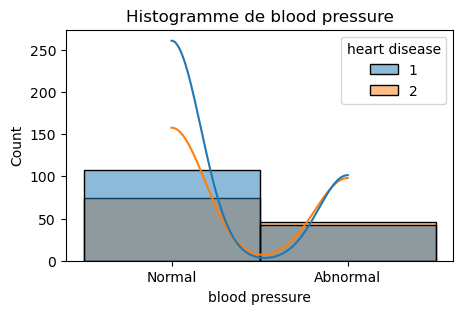

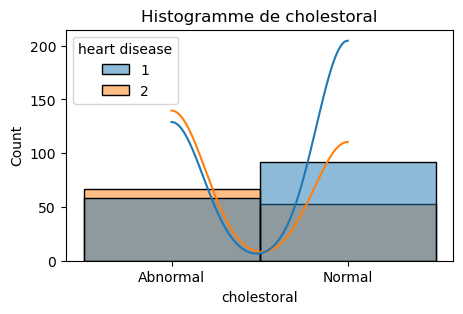

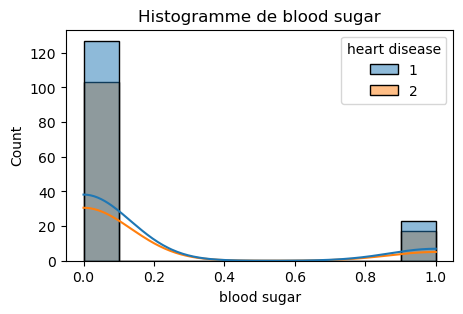

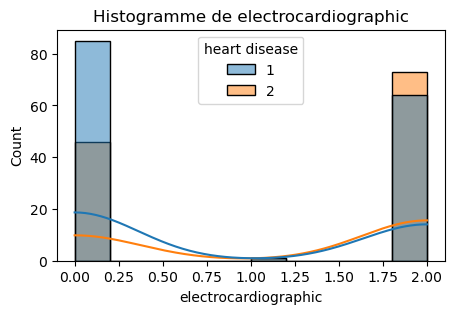

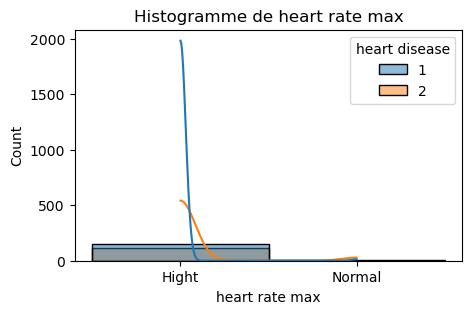

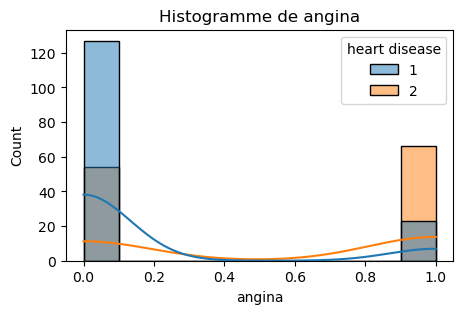

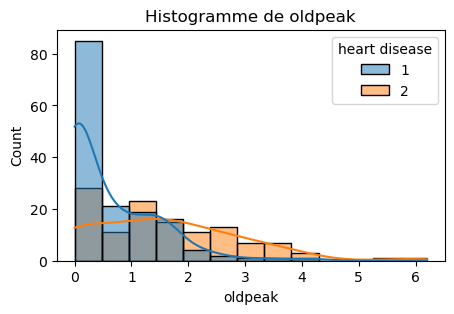

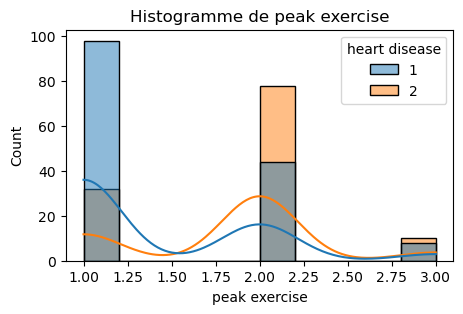

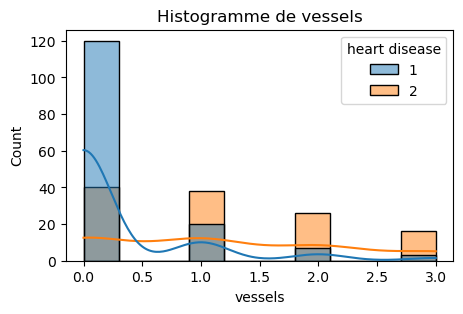

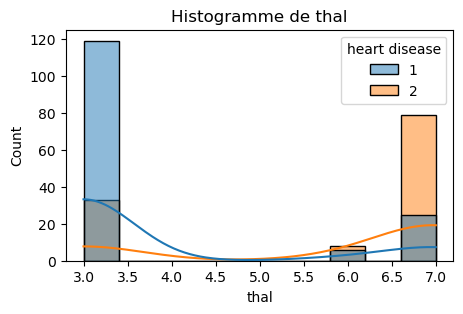

In [82]:
figsize = (5,3)
my_histplot(df, attributs, class_name, figsize)

Pairplot.

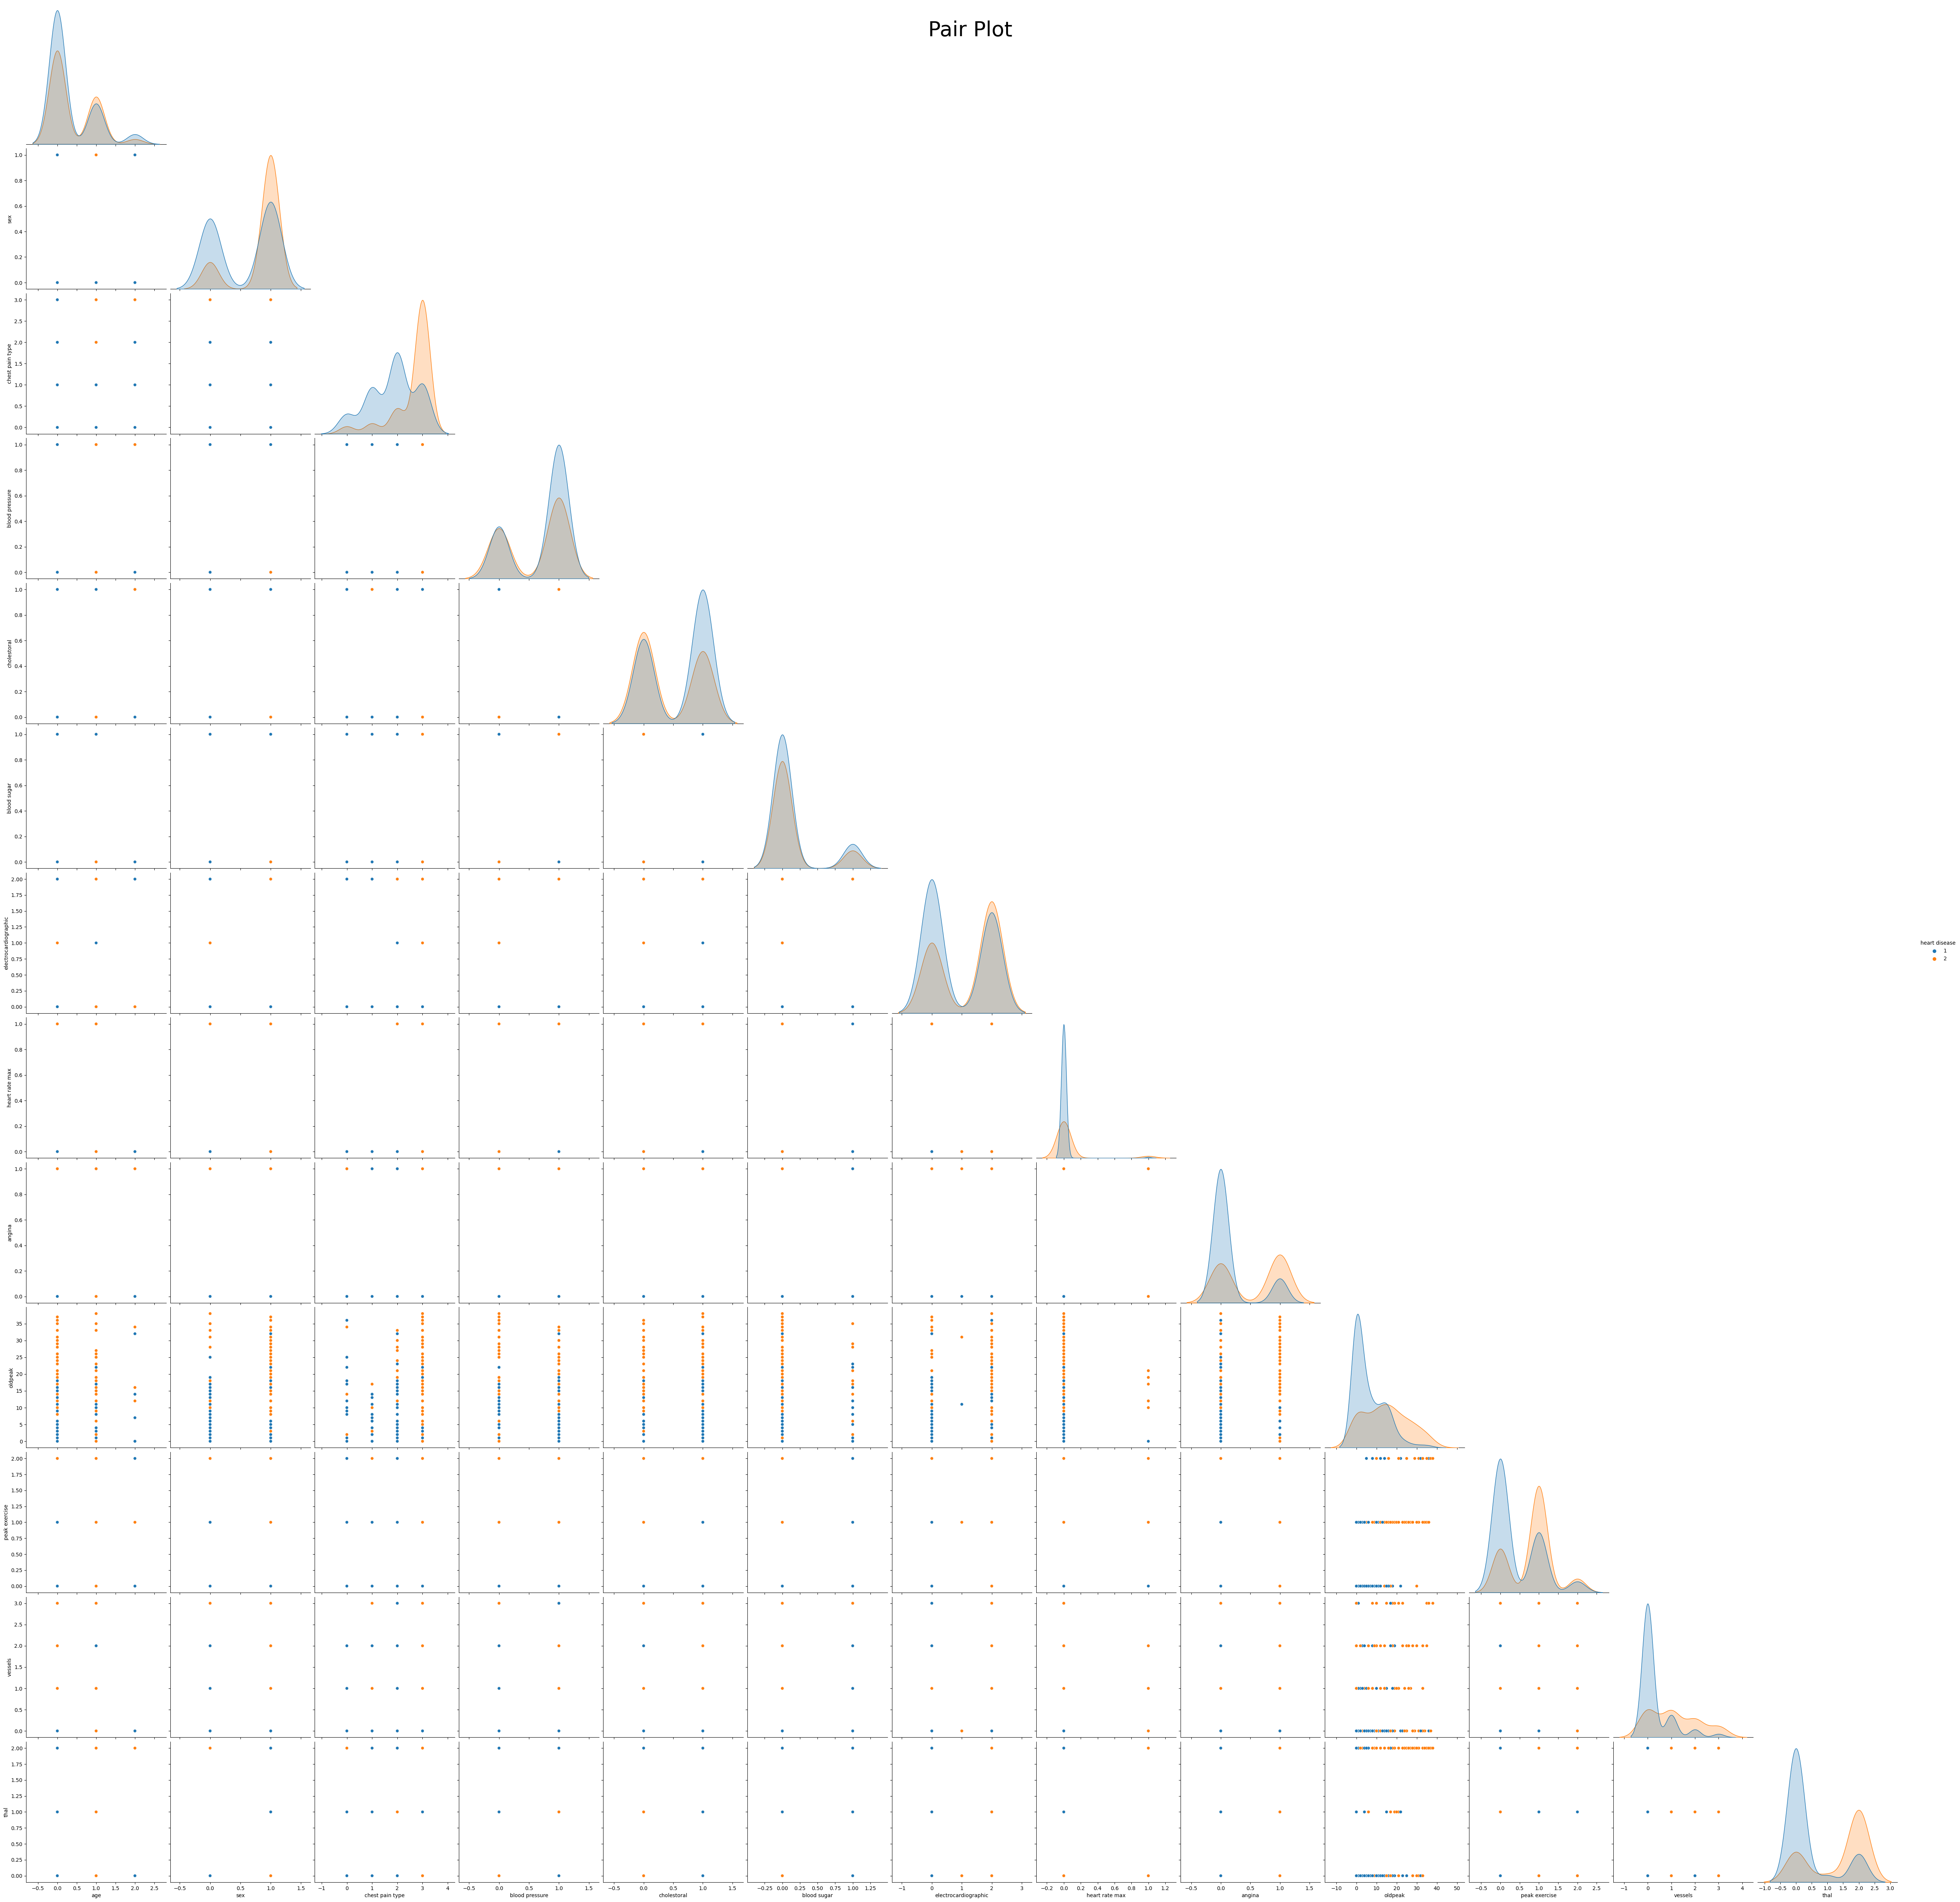

In [83]:
my_pairplot(df_prepro, class_name)

## Preprocessing.

Suppression valeurs aberrantes.

In [84]:
df_prepro = remove_outliers(df_prepro)
df_prepro

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
1,1.00,0.00,2.00,1.00,0.00,0.00,2.00,0.00,0.00,16.00,1.00,0.00,2.00,1
2,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,2.00,2
3,1.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,1.00,2.00,1
4,1.00,0.00,1.00,1.00,0.00,0.00,2.00,0.00,1.00,2.00,0.00,1.00,0.00,1
5,1.00,1.00,3.00,1.00,1.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,2.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,10.00,2.00,0.00,2.00,2
265,0.00,1.00,2.00,0.00,1.00,1.00,0.00,0.00,0.00,5.00,0.00,0.00,2.00,1
266,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1
267,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,13.00,1.00,0.00,0.00,1


### Normalisation.

#### Normalisation attributs.

In [85]:
df_prepro = normalisation_attributs(df_prepro, attributs)
df_prepro

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
1,0.50,0.00,0.50,1.00,0.00,0.00,1.00,0.00,0.00,0.43,0.50,0.00,1.00,1
2,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,1.00,2
3,0.50,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.05,0.50,0.50,1.00,1
4,0.50,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.05,0.00,0.50,0.00,1
5,0.50,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.27,1.00,0.00,1.00,2
265,0.00,1.00,0.50,0.00,1.00,1.00,0.00,0.00,0.00,0.14,0.00,0.00,1.00,1
266,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1
267,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.35,0.50,0.00,0.00,1


#### Normalisation classe.

In [86]:
df_prepro = normalisation_classe(df_prepro, class_name)
df_prepro

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
1,0.50,0.00,0.50,1.00,0.00,0.00,1.00,0.00,0.00,0.43,0.50,0.00,1.00,0
2,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,1.00,1
3,0.50,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.05,0.50,0.50,1.00,0
4,0.50,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.05,0.00,0.50,0.00,0
5,0.50,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.27,1.00,0.00,1.00,1
265,0.00,1.00,0.50,0.00,1.00,1.00,0.00,0.00,0.00,0.14,0.00,0.00,1.00,0
266,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0
267,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.35,0.50,0.00,0.00,0


## Classification.

### Liste des modèles.

In [87]:
classifiers = {
    "Gaussian Process": GaussianProcessClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Nearest Neighbors": KNeighborsClassifier(),
    # "Linear SVM": SVC(kernel="linear", probability=True),
    # "RBF SVM": SVC(kernel="rbf", probability=True),
    # "Neural Net": MLPClassifier(max_iter=2000),
    # "Naive Bayes": GaussianNB(),
    # "Decision Tree": DecisionTreeClassifier(),
    # "AdaBoost": AdaBoostClassifier(),
    # "QDA": QuadraticDiscriminantAnalysis(),
}

### Sans *features selection*.

Decoupage.

In [88]:
X_train_sans_feature_select, X_test_sans_feature_select, y_train_sans_feature_select, y_test_sans_feature_select = decoupage(df_prepro, attributs, class_name)

X_train.shape: (184, 13), X_test.shape: (47, 13), y_train.shape: (184,), y_test.shape: (47,)


Entrainement des modèles.

In [89]:
liste_predictions_sans_feature_select = entrainement(classifiers, X_train_sans_feature_select, y_train_sans_feature_select, X_test_sans_feature_select)

Gaussian Process
fitting...Done
predicting labels...Done

Random Forest
fitting...Done
predicting labels...Done

Nearest Neighbors
fitting...Done
predicting labels...Done



Evaluation.

Rapport de classification pour Gaussian Process
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.79      0.75      0.77        20

    accuracy                           0.81        47
   macro avg       0.81      0.80      0.80        47
weighted avg       0.81      0.81      0.81        47



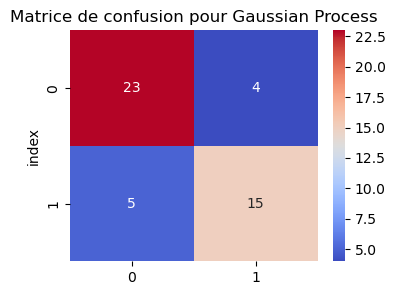

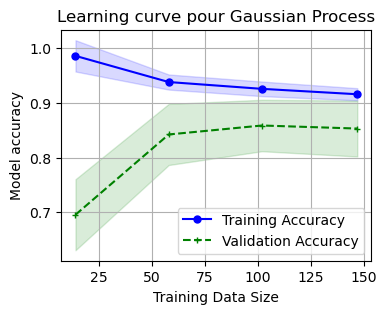

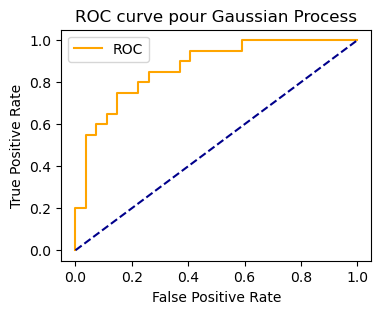

Rapport de classification pour Random Forest
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.75      0.75      0.75        20

    accuracy                           0.79        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.79      0.79      0.79        47



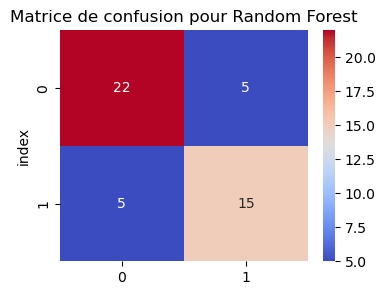

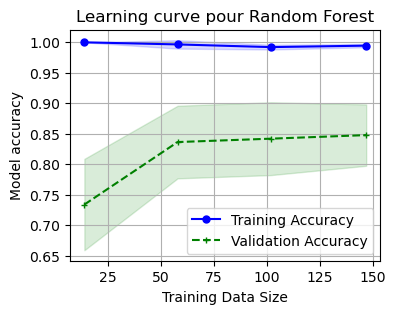

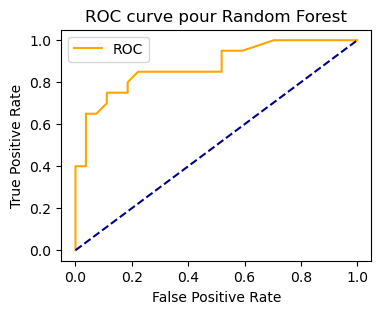

Rapport de classification pour Nearest Neighbors
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        27
           1       0.80      0.60      0.69        20

    accuracy                           0.77        47
   macro avg       0.78      0.74      0.75        47
weighted avg       0.77      0.77      0.76        47



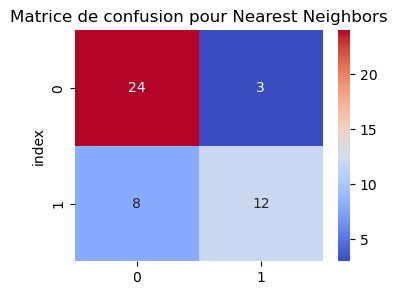

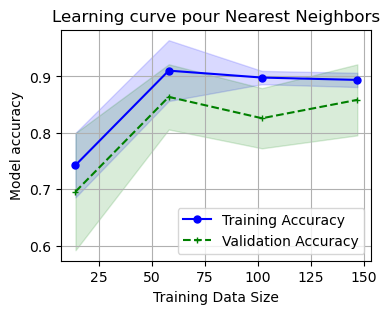

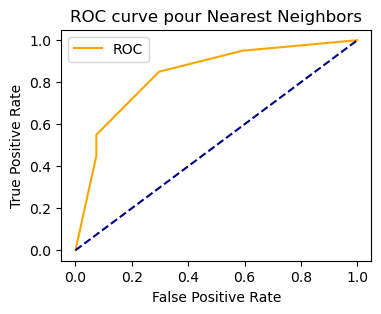

In [90]:
evaluation("sans_feature_select", liste_predictions_sans_feature_select, df_prepro, class_name, X_train_sans_feature_select, X_test_sans_feature_select, y_train_sans_feature_select, y_test_sans_feature_select)

Analyse: <br>
Sans *feature selection*, les modèles sont relativement bon. Ils arrivent à avoir une précision autour de 80%. Ils sont cependant meilleurs pour reconnaître la classe 0, (précision plus haute et recall plus haut). <br>
Les courbes d'apprentissages ne montrent pas de signe *d'overfitting* ou *d'underfitting*. Elles montrent que les modèles ont bien appris, à l'exception du *Random Forest*, nous pouvons ajouter des données pour augmenter la précision. <br>
Les *ROC curve* corroborent avec les matrices de confusion, les modèles sont bien entrainés.

Création d'une liste stockant les précisions, et ajout de la précision des modèles ci-dessous.

In [91]:
accs = []
acc = [accuracy_score(y_test_sans_feature_select, pred) for _, _, pred in liste_predictions_sans_feature_select]
accs.append(acc)

### Avec *Features selection*.

#### Reduct.

Calcul du reduct.

In [92]:
attributs_reduct = reduct(df_prepro, class_name)

C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\252999814.py:15: FutureWarning: In a futur

reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'electrocardiographic', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'cholestoral', 'electrocardiographic', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'blood sugar', 'electrocardiographic', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'electrocardiographic', 'heart rate max', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'electrocardiographic', 'angina', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'electrocardiographic', 'oldpeak', 'peak exercise', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type', 'blood pressure', 'cholestoral', 'blood sugar', 'electrocardiographic', 'oldpeak', 'vessels', 'thal']
reduc trouvé : ['age', 'sex', 'chest pain type',

Affichage du reduct.

In [93]:
attributs_reduct

[['age',
  'sex',
  'chest pain type',
  'blood pressure',
  'electrocardiographic',
  'oldpeak',
  'vessels',
  'thal']]

Similarité.

In [94]:
counter_cosine_similarity(attributs, attributs_reduct[0])

0.7844645405527361

Découpage.

In [95]:
df_prepro_reduct = df_prepro[attributs_reduct[0] + [class_name]]
X_train_reduct, X_test_reduct, y_train_reduct, y_test_reduct = decoupage(df_prepro_reduct, attributs_reduct[0], class_name)

X_train.shape: (184, 8), X_test.shape: (47, 8), y_train.shape: (184,), y_test.shape: (47,)


In [96]:
# colors = ["blue", "red", "green"]
# for index, (nom, model_fit, _) in enumerate(liste_predictions_sans_feature_select):
# 	probs = model_fit.predict_proba(X_test_sans_feature_select) 
# 	probs = probs[:, 1]
# 	fper, tper, thresholds = roc_curve(y_test_sans_feature_select, probs) 
# 	plt.plot(fper, tper, color=colors[index], label=f"{nom}")

# plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title("Comparaison des ROC curve de chaque algorithme")
# plt.legend()
# plt.savefig(f"{OUT_IMG}comparaison/roc_curve.png", bbox_inches='tight')
# plt.show()

Entrainement des modèles.

In [97]:
liste_predictions_reduct = entrainement(classifiers, X_train_reduct, y_train_reduct, X_test_reduct)

Gaussian Process
fitting...Done
predicting labels...Done

Random Forest
fitting...Done
predicting labels...Done

Nearest Neighbors
fitting...Done
predicting labels...Done



Evaluation.

Rapport de classification pour Gaussian Process
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.81      0.85      0.83        20

    accuracy                           0.85        47
   macro avg       0.85      0.85      0.85        47
weighted avg       0.85      0.85      0.85        47



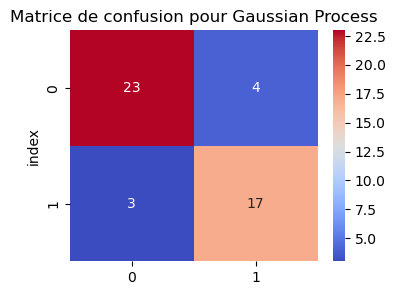

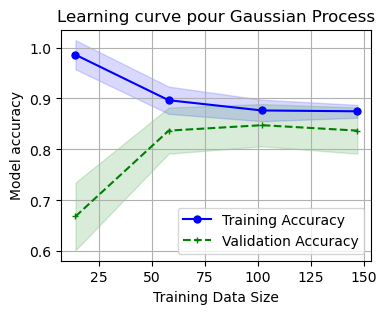

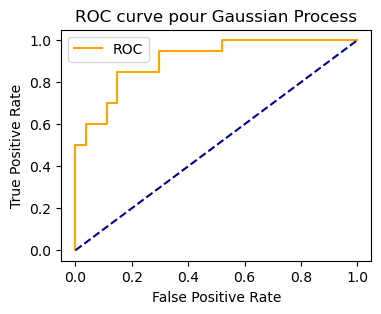

Rapport de classification pour Random Forest
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        27
           1       0.88      0.75      0.81        20

    accuracy                           0.85        47
   macro avg       0.86      0.84      0.84        47
weighted avg       0.85      0.85      0.85        47



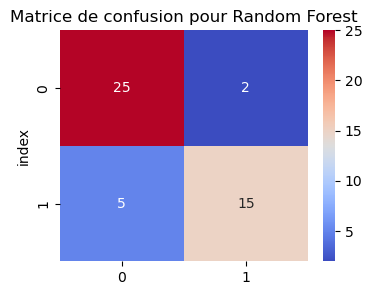

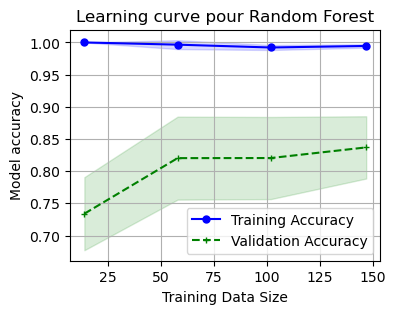

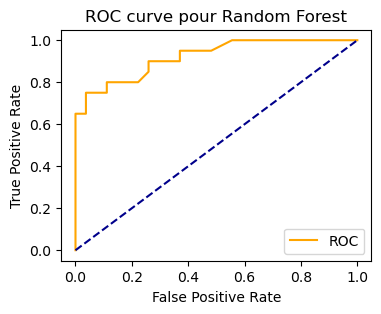

Rapport de classification pour Nearest Neighbors
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.75      0.75      0.75        20

    accuracy                           0.79        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.79      0.79      0.79        47



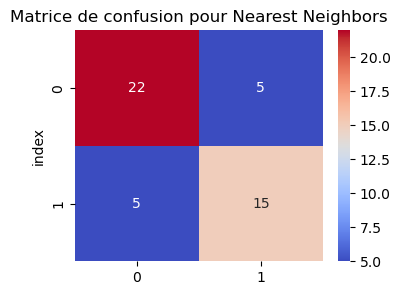

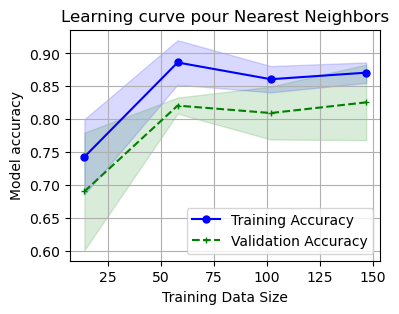

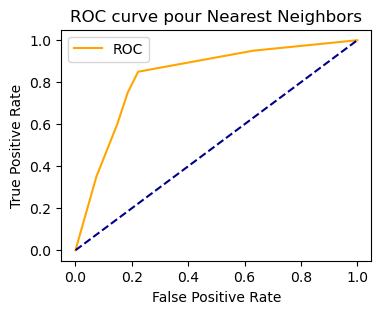

In [98]:
evaluation("reduct_rst", liste_predictions_reduct, df_prepro_reduct, class_name, X_train_reduct, X_test_reduct, y_train_reduct, y_test_reduct)

Analyse: <br>
Les modèles appliqué sur le dataset avec les attributs réduits sont plus performants. Ils ont une précision plus haute et des *recalls* plus hauts, à l'exception du *KNN*. Il y cepedant toujours une différence entre les classes.

In [99]:
acc = [accuracy_score(y_test_reduct, pred) for _, _, pred in liste_predictions_reduct]
accs.append(acc)

#### *Quickreduct*.

Calcul du quickreduct.

In [100]:
attributs_quickreduct = quickReduct(df_prepro, class_name)

C : ['age', 'sex', 'chest pain type', 'blood pressure', 'cholestoral', 'blood sugar', 'electrocardiographic', 'heart rate max', 'angina', 'oldpeak', 'peak exercise', 'vessels', 'thal']
λC : 0.9783549783549783 

λT([]) = 0
C_R ['age', 'sex', 'chest pain type', 'blood pressure', 'cholestoral', 'blood sugar', 'electrocardiographic', 'heart rate max', 'angina', 'oldpeak', 'peak exercise', 'vessels', 'thal']
x : age
λRUx(['age']) = 0.0
x : sex
λRUx(['sex']) = 0.0
x : chest pain type
λRUx(['chest pain type']) = 0.0
x : blood pressure
λRUx(['blood pressure']) = 0.0
x : cholestoral
λRUx(['cholestoral']) = 0.0
x : blood sugar
λRUx(['blood sugar']) = 0.0
x : electrocardiographic
λRUx(['electrocardiographic']) = 0.0
x : heart rate max
λRUx(['heart rate max']) = 0.0
x : angina
λRUx(['angina']) = 0.0
x : oldpeak
λRUx(['oldpeak']) = 0.19047619047619047
changement R = ['oldpeak']
x : peak exercise
λRUx(['peak exercise']) = 0.0
x : vessels
λRUx(['vessels']) = 0.0
x : thal
λRUx(['thal']) = 0.0
λR(['old

C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g in group:
C:\Users\micka\AppData\Local\Temp\ipykernel_7752\3352807690.py:15: FutureWarning: In a f

x : chest pain type
λRUx(['oldpeak', 'chest pain type']) = 0.36796536796536794
changement R = ['oldpeak', 'chest pain type']
x : blood pressure
λRUx(['oldpeak', 'blood pressure']) = 0.23809523809523808
x : cholestoral
λRUx(['oldpeak', 'cholestoral']) = 0.2683982683982684
x : blood sugar
λRUx(['oldpeak', 'blood sugar']) = 0.2597402597402597
x : electrocardiographic
λRUx(['oldpeak', 'electrocardiographic']) = 0.2597402597402597
x : heart rate max
λRUx(['oldpeak', 'heart rate max']) = 0.21212121212121213
x : angina
λRUx(['oldpeak', 'angina']) = 0.30303030303030304
x : peak exercise
λRUx(['oldpeak', 'peak exercise']) = 0.2813852813852814
x : vessels
λRUx(['oldpeak', 'vessels']) = 0.4329004329004329
changement R = ['oldpeak', 'vessels']
x : thal
λRUx(['oldpeak', 'thal']) = 0.46320346320346323
changement R = ['oldpeak', 'thal']
λR(['oldpeak', 'thal']) = 0.46320346320346323
λT(['oldpeak', 'thal']) = 0.46320346320346323
C_R ['age', 'sex', 'chest pain type', 'blood pressure', 'cholestoral', 'bl

Affichage du quickreduct.

In [101]:
attributs_quickreduct

['oldpeak',
 'thal',
 'vessels',
 'chest pain type',
 'sex',
 'age',
 'blood pressure',
 'electrocardiographic']

Similarité.

In [102]:
counter_cosine_similarity(attributs, attributs_quickreduct)

0.7844645405527361

Découpage.

In [103]:
df_prepro_quickreduct = df_prepro[attributs_quickreduct + [class_name]]
X_train_quickreduct, X_test_quickreduct, y_train_quickreduct, y_test_quickreduct = decoupage(df_prepro_quickreduct, attributs_quickreduct, class_name)

X_train.shape: (184, 8), X_test.shape: (47, 8), y_train.shape: (184,), y_test.shape: (47,)


Entrainement des modèles.

In [104]:
liste_predictions_quickreduct = entrainement(classifiers, X_train_quickreduct, y_train_quickreduct, X_test_quickreduct)

Gaussian Process
fitting...Done
predicting labels...Done

Random Forest
fitting...Done
predicting labels...Done

Nearest Neighbors
fitting...Done
predicting labels...Done



Evaluation.

Rapport de classification pour Gaussian Process
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.81      0.85      0.83        20

    accuracy                           0.85        47
   macro avg       0.85      0.85      0.85        47
weighted avg       0.85      0.85      0.85        47



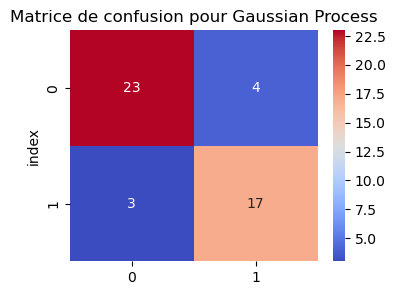

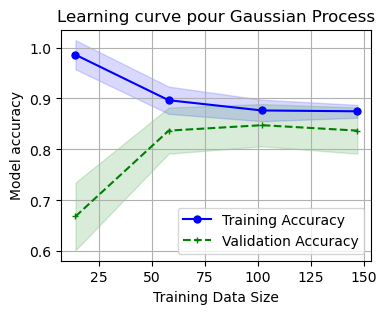

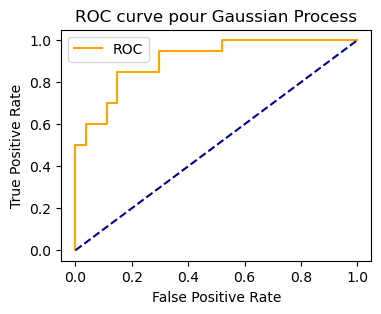

Rapport de classification pour Random Forest
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.84      0.80      0.82        20

    accuracy                           0.85        47
   macro avg       0.85      0.84      0.85        47
weighted avg       0.85      0.85      0.85        47



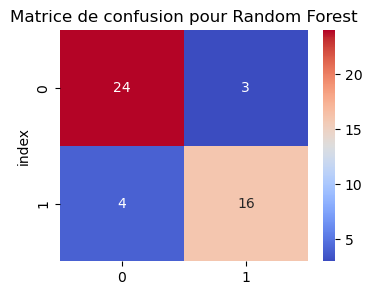

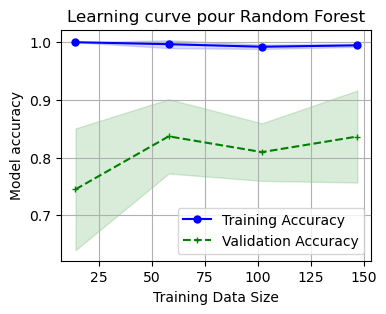

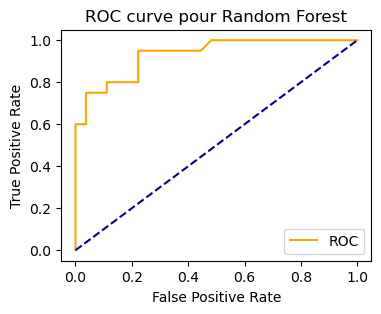

Rapport de classification pour Nearest Neighbors
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.75      0.75      0.75        20

    accuracy                           0.79        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.79      0.79      0.79        47



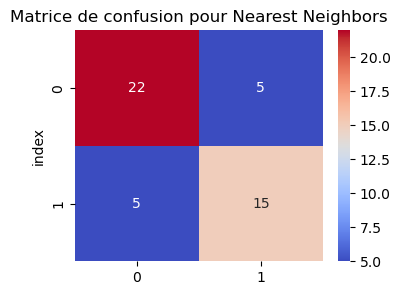

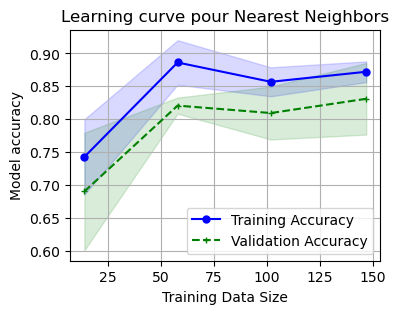

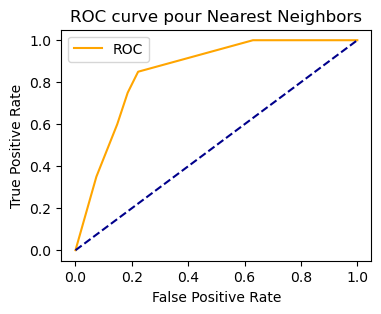

In [105]:
evaluation("quickReduct", liste_predictions_quickreduct, df_prepro_quickreduct, class_name, X_train_quickreduct, X_test_quickreduct, y_train_quickreduct, y_test_quickreduct)

In [106]:
acc = [accuracy_score(y_test_quickreduct, pred) for _, _, pred in liste_predictions_quickreduct]
accs.append(acc)

#### *Variance threshold*.

Calcul de la variance pour chaque attributs.

In [107]:
X_train_sans_feature_select.var(axis=0)

array([0.06975868, 0.2251595 , 0.14684989, 0.20734877, 0.24926158,
       0.11740903, 0.24827948, 0.03154537, 0.22161508, 0.06987796,
       0.08931209, 0.1304274 , 0.22146001])

Selection des attributs avec une variance > 0.2.

In [108]:
selector = VarianceThreshold(threshold=0.2)
selector.fit_transform(X_train_sans_feature_select)
attributs_variance = list(np.array(attributs)[selector.get_support()])
attributs_variance

['sex',
 'blood pressure',
 'cholestoral',
 'electrocardiographic',
 'angina',
 'thal']

Découpage.

In [109]:
df_prepro_variance = df_prepro[attributs_variance + [class_name]]
X_train_variance, X_test_variance, y_train_variance, y_test_variance = decoupage(df_prepro_variance, attributs_variance, class_name)

X_train.shape: (184, 6), X_test.shape: (47, 6), y_train.shape: (184,), y_test.shape: (47,)


Entrainement des modèles.

In [110]:
liste_predictions_variance = entrainement(classifiers, X_train_variance, y_train_variance, X_test_variance)

Gaussian Process
fitting...Done
predicting labels...Done

Random Forest
fitting...Done
predicting labels...Done

Nearest Neighbors
fitting...Done
predicting labels...Done



Evaluation.

Rapport de classification pour Gaussian Process
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.70      0.80      0.74        20

    accuracy                           0.77        47
   macro avg       0.76      0.77      0.76        47
weighted avg       0.77      0.77      0.77        47



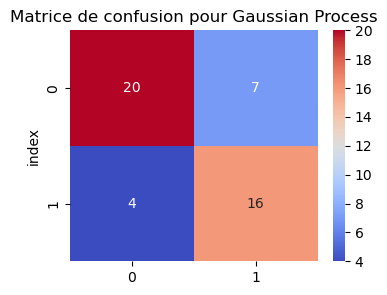

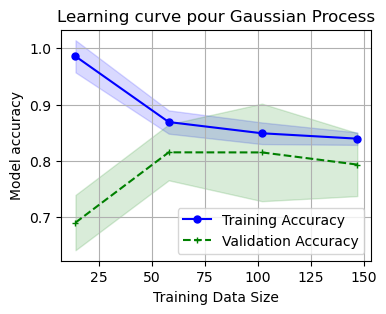

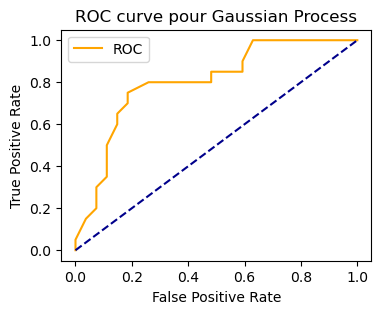

Rapport de classification pour Random Forest
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.71      0.75      0.73        20

    accuracy                           0.77        47
   macro avg       0.76      0.76      0.76        47
weighted avg       0.77      0.77      0.77        47



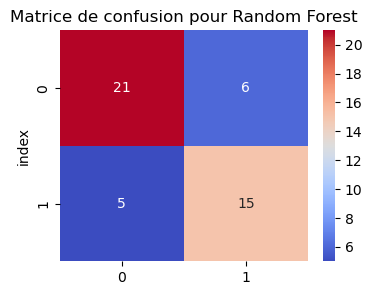

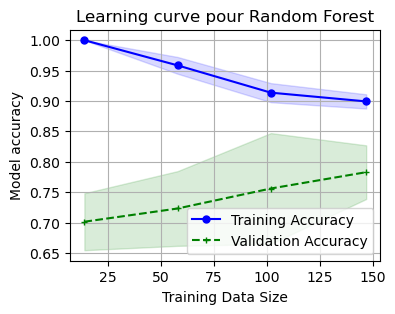

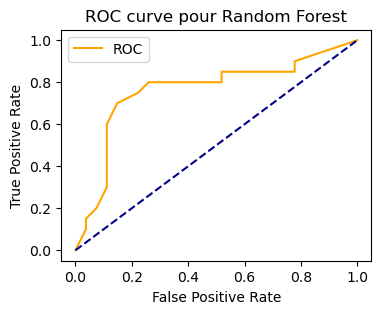

Rapport de classification pour Nearest Neighbors
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.70      0.70      0.70        20

    accuracy                           0.74        47
   macro avg       0.74      0.74      0.74        47
weighted avg       0.74      0.74      0.74        47



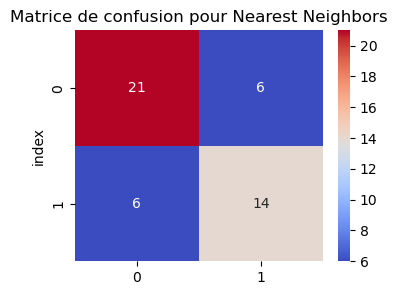

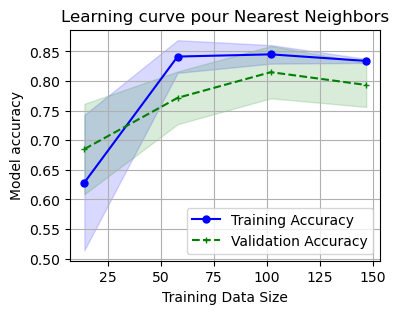

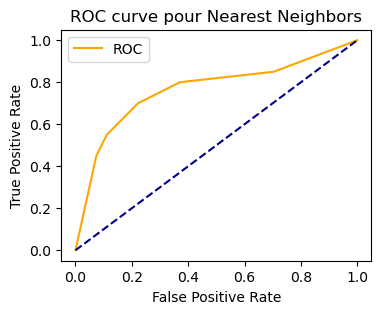

In [111]:
evaluation("variance", liste_predictions_variance, df_prepro_variance, class_name, X_train_variance, X_test_variance, y_train_variance, y_test_variance)

In [112]:
acc = [accuracy_score(y_test_variance, pred) for _, _, pred in liste_predictions_variance]
accs.append(acc)

#### *Fuzzy rough set*.

In [113]:
X_train_values, y_train_values = copy.deepcopy(X_train_sans_feature_select), copy.deepcopy(y_train_sans_feature_select)
X_test_values, y_test_values = copy.deepcopy(X_test_sans_feature_select), copy.deepcopy(y_test_sans_feature_select)

Lien exemple: https://github.com/oulenz/fuzzy-rough-learn/blob/master/examples/preprocessors/frfs.py

Calcul des attributs avec Fuzzy Rough Set.

In [114]:
# Create an instance of the FRFS preprocessor and process the data.
preprocessor = FRFS(n_features=8)
model = preprocessor(X_train_values, y_train_values)
X_train_select = model(X_train_values)

In [115]:
# obtenir indice attributs
indexes = []
for index, x in enumerate(X_train_values.transpose()):
	for x_select in X_train_select.transpose():
		comparaison = x == x_select
		(comparaison.all() and index not in indexes) and indexes.append(index)
"indexes", indexes

('indexes', [0, 1, 2, 3, 4, 5, 6, 9])

In [116]:
# obtenir nom attributs
support = [index in indexes for index, _ in enumerate(attributs)]
attributs_fuzzy = list(np.array(attributs)[support])
"attributs_fuzzy", attributs_fuzzy

('attributs_fuzzy',
 ['age',
  'sex',
  'chest pain type',
  'blood pressure',
  'cholestoral',
  'blood sugar',
  'electrocardiographic',
  'oldpeak'])

Découpage.

In [117]:
df_prepro_fuzzy = df_prepro[attributs_fuzzy + [class_name]]
X_train_fuzzy, X_test_fuzzy, y_train_fuzzy, y_test_fuzzy = decoupage(df_prepro_fuzzy, attributs_fuzzy, class_name)

X_train.shape: (184, 8), X_test.shape: (47, 8), y_train.shape: (184,), y_test.shape: (47,)


Entrainement des modèles.

In [118]:
# Create an instance of the FRNN classifier, construct the model, and query on the test set.
clf = FRNN(upper_weights=None, lower_weights=None, upper_k=1, lower_k=1)
model2 = clf(X_train_fuzzy, y_train_fuzzy)
scores = model2(X_test_fuzzy)

# Convert scores to probabilities and calculate the AUROC.
probabilities = probabilities_from_scores(scores)
true_proba = probabilities[:,1]
auroc = roc_auc_score(y_test_fuzzy, true_proba, multi_class='ovo')
"auroc", auroc

('auroc', 0.7777777777777778)

Evaluation.

In [119]:
classes = select_class(scores)
accuracy = accuracy_score(y_test_values, classes)
"accuracy", accuracy

('accuracy', 0.723404255319149)

In [120]:
my_classification_report(class_name, classes, y_test_fuzzy)

Rapport de classification pour heart disease
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        27
           1       0.77      0.50      0.61        20

    accuracy                           0.72        47
   macro avg       0.74      0.69      0.70        47
weighted avg       0.73      0.72      0.71        47



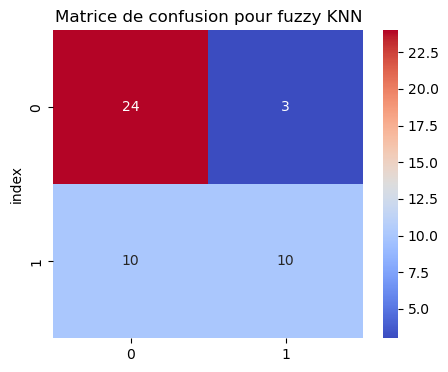

In [121]:
plot_confusion_matrix("fuzzy rst", "fuzzy KNN", df_prepro, class_name, classes, y_test_fuzzy, (5, 4))	

Entrainement des modèles.

In [122]:
liste_predictions_fuzzy = entrainement(classifiers, X_train_fuzzy, y_train_fuzzy, X_test_fuzzy)

Gaussian Process
fitting...Done
predicting labels...Done

Random Forest
fitting...Done
predicting labels...Done

Nearest Neighbors
fitting...Done
predicting labels...Done



Evaluation.

Rapport de classification pour Gaussian Process
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.72      0.65      0.68        20

    accuracy                           0.74        47
   macro avg       0.74      0.73      0.73        47
weighted avg       0.74      0.74      0.74        47



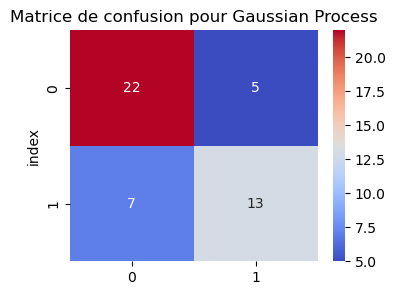

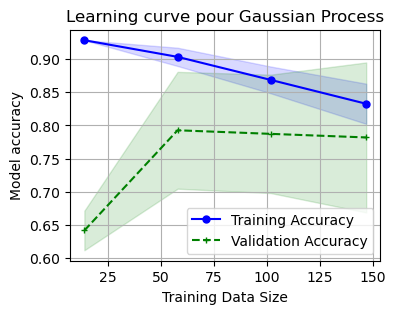

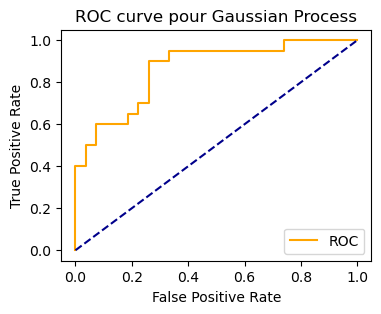

Rapport de classification pour Random Forest
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        27
           1       0.87      0.65      0.74        20

    accuracy                           0.81        47
   macro avg       0.82      0.79      0.80        47
weighted avg       0.82      0.81      0.80        47



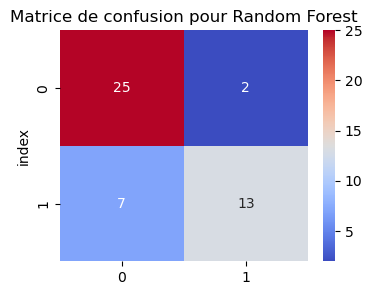

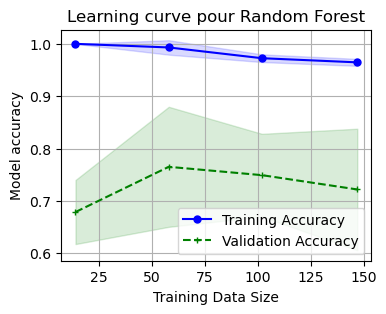

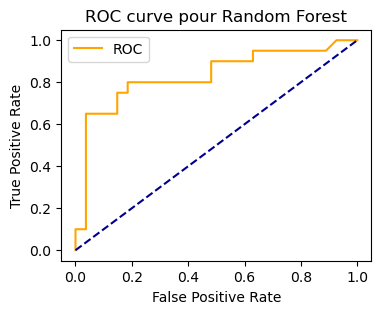

Rapport de classification pour Nearest Neighbors
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.72      0.65      0.68        20

    accuracy                           0.74        47
   macro avg       0.74      0.73      0.73        47
weighted avg       0.74      0.74      0.74        47



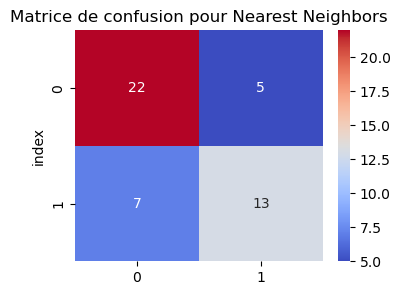

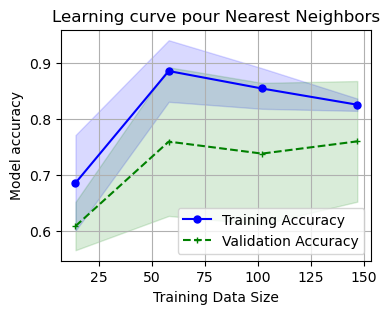

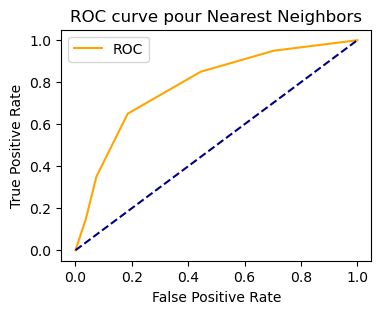

In [123]:
evaluation("fuzzy_rst", liste_predictions_fuzzy, df_prepro_fuzzy, class_name, X_train_fuzzy, X_test_fuzzy, y_train_fuzzy, y_test_fuzzy)

In [124]:
acc = [accuracy_score(y_test_fuzzy, pred) for _, _, pred in liste_predictions_fuzzy]
accs.append(acc)

## Comparaison.

In [125]:
liste_predictions_all = [
	("sans_reduc", liste_predictions_sans_feature_select), 
	("reduct_rst", liste_predictions_reduct),
	("quickreduct", liste_predictions_quickreduct),
	("variance", liste_predictions_variance),
	("fuzzy", liste_predictions_fuzzy)
]

In [126]:
conf_matrix_sans_reduc = []
print(liste_predictions_all[0][0])
for nom, model_fit, y_pred_test in liste_predictions_all[0][1]:
	print(nom)
	labels = np.unique(df_prepro[class_name].values)
	conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)
	print(conf_matrix)
	conf_matrix_sans_reduc.append(conf_matrix)

sans_reduc
Gaussian Process
[[23  4]
 [ 5 15]]
Random Forest
[[22  5]
 [ 5 15]]
Nearest Neighbors
[[24  3]
 [ 8 12]]


Nous calculons les différences entre les matrices de corrélation sans *feature selection* et avec. <br>
Pour les valeurs de vrais négatifs et de faux négatifs, si la valeur est négative, cela indique que le modèle fait plus d'erreurs à l'inverse il fait moins d'erreur. <br>
Pour les valeurs de faux négatifs et de faux positifs, c'est l'inverse, si la valeur est négative, cela indique que le modèle fait moins d'erreurs à l'inverse il fait plus d'erreurs.

In [127]:
print(liste_predictions_all[1][0])
for index, (nom, model_fit, y_pred_test) in enumerate(liste_predictions_all[1][1]):
	print(nom)
	labels = np.unique(df_prepro[class_name].values)
	conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)
	diff_matrix = conf_matrix - conf_matrix_sans_reduc[index]
	print(diff_matrix)

reduct_rst
Gaussian Process
[[ 0  0]
 [-2  2]]
Random Forest
[[ 3 -3]
 [ 0  0]]
Nearest Neighbors
[[-2  2]
 [-3  3]]


Le *reduct* améliore grandement la précision sur la deuxième classe pour les trois modèles. <br>
Il améliorer un peu la précision sur la première classe pour le *Random Forest*. <br>
Mais il baisse légerement la précision sur la première classe dans le *Gaussian Process* et le *Nearest Neighbors*. <br>

In [128]:
print(liste_predictions_all[2][0])
for index, (nom, model_fit, y_pred_test) in enumerate(liste_predictions_all[2][1]):
	print(nom)
	labels = np.unique(df_prepro[class_name].values)
	conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)
	diff_matrix = conf_matrix - conf_matrix_sans_reduc[index]
	print(diff_matrix)

quickreduct
Gaussian Process
[[ 0  0]
 [-2  2]]
Random Forest
[[ 2 -2]
 [-1  1]]
Nearest Neighbors
[[-2  2]
 [-3  3]]


Le *quickreduct* obtient presque les mêmes résultats que le *reduct* mais améliore moins le *Random Forest*.

In [129]:
print(liste_predictions_all[3][0])
for index, (nom, model_fit, y_pred_test) in enumerate(liste_predictions_all[3][1]):
	print(nom)
	labels = np.unique(df_prepro[class_name].values)
	conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)
	diff_matrix = conf_matrix - conf_matrix_sans_reduc[index]
	print(diff_matrix)

variance
Gaussian Process
[[-3  3]
 [-1  1]]
Random Forest
[[-1  1]
 [ 0  0]]
Nearest Neighbors
[[-3  3]
 [-2  2]]


Les résultats du *variance* ne sont pas significatifs. En effet, il augment la présicion sur la deuxième classe mais réduit la précision sur la première classe.

In [130]:
print(liste_predictions_all[4][0])
for index, (nom, model_fit, y_pred_test) in enumerate(liste_predictions_all[4][1]):
	print(nom)
	labels = np.unique(df_prepro[class_name].values)
	conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)
	diff_matrix = conf_matrix - conf_matrix_sans_reduc[index]
	print(diff_matrix)

fuzzy
Gaussian Process
[[-1  1]
 [ 2 -2]]
Random Forest
[[ 3 -3]
 [ 2 -2]]
Nearest Neighbors
[[-2  2]
 [-1  1]]


De même pour les résultats du *fuzzy* même s'ils reste meilleurs que ceux de *variance*.

#### Précision.

Construction de la listes de précisions pour les modèles sans amélioration, avec et sans *feature selection*.

In [131]:
types = ["sans_feature", "reduct_rst", "quickreduct", "variance", "fuzzy"]
data = [[type] + acc for type, acc in zip(types, accs)]
data

[['sans_feature', 0.8085106382978723, 0.7872340425531915, 0.7659574468085106],
 ['reduct_rst', 0.851063829787234, 0.851063829787234, 0.7872340425531915],
 ['quickreduct', 0.851063829787234, 0.851063829787234, 0.7872340425531915],
 ['variance', 0.7659574468085106, 0.7659574468085106, 0.7446808510638298],
 ['fuzzy', 0.7446808510638298, 0.8085106382978723, 0.7446808510638298]]

Construction du dataframe.

In [132]:
df_acc = pd.DataFrame(data, columns=["type", "Gaussian Process", "Random Forest", "Nearest Neighbors"])
df_acc.set_index("type", inplace=True)
df_acc

,Gaussian Process,Random Forest,Nearest Neighbors
type,,,
sans_feature,0.81,0.79,0.77
reduct_rst,0.85,0.85,0.79
quickreduct,0.85,0.85,0.79
variance,0.77,0.77,0.74
fuzzy,0.74,0.81,0.74


Affichage des précisions.

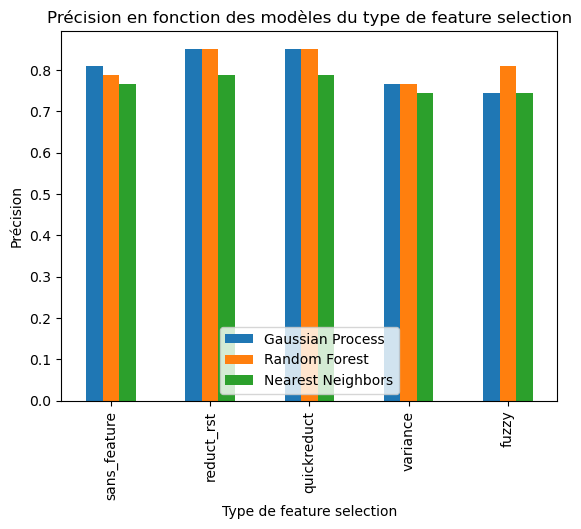

In [133]:
df_acc.plot.bar()
plt.xlabel("Type de feature selection")
plt.ylabel("Précision")
plt.title("Précision en fonction des modèles du type de feature selection")
plt.savefig(f"{OUT_IMG}comparaison/accuracy.png", bbox_inches='tight')
plt.show()

#### Affichage des vrais positifs et des faux positifs.

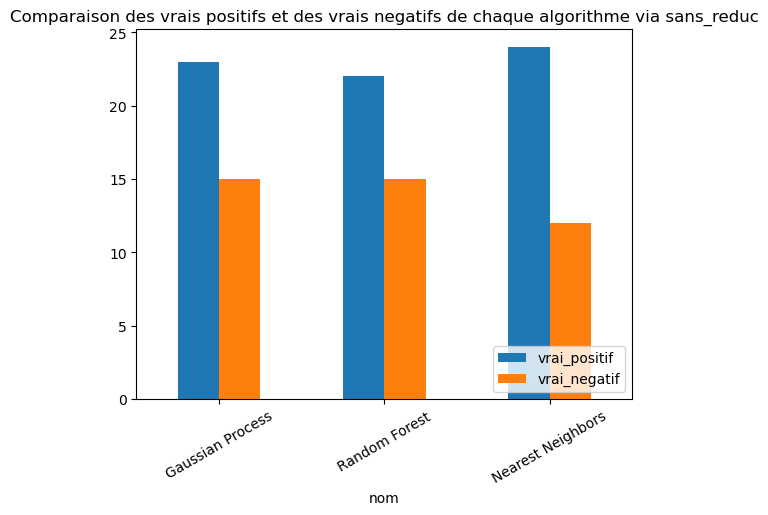

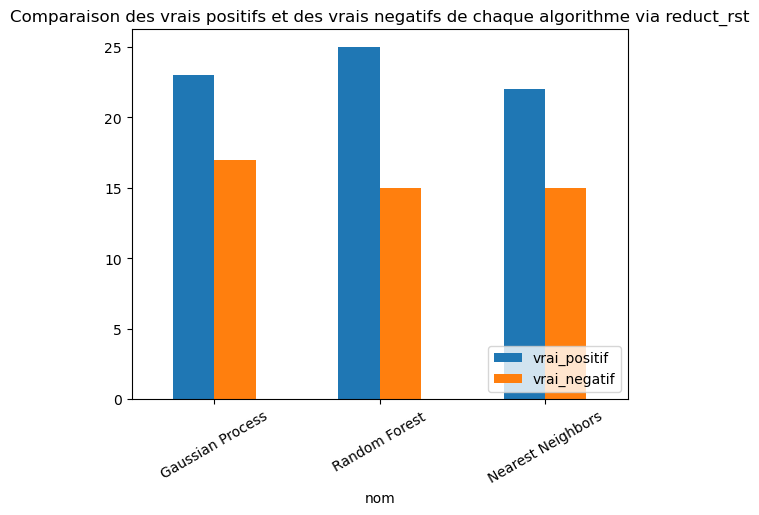

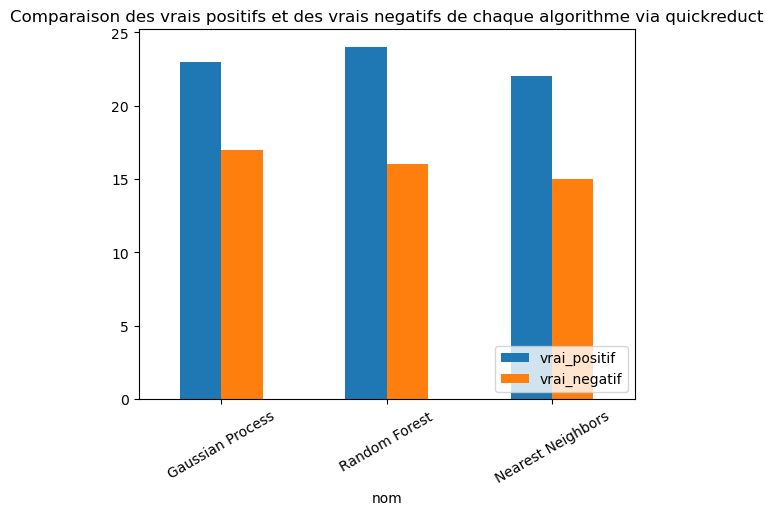

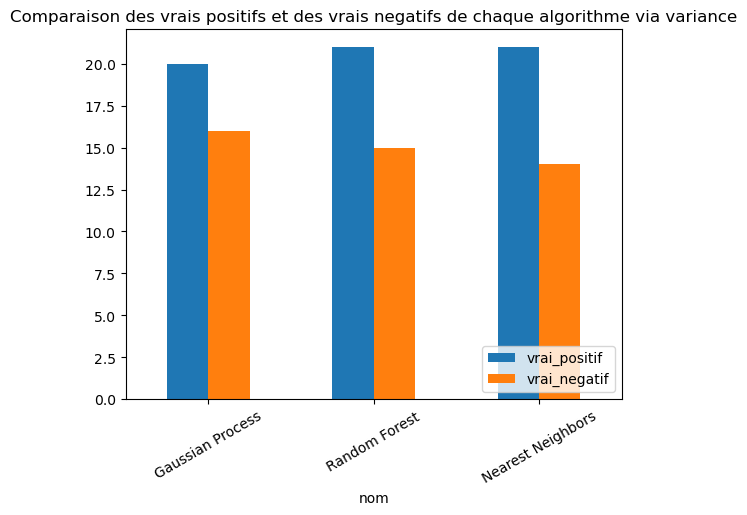

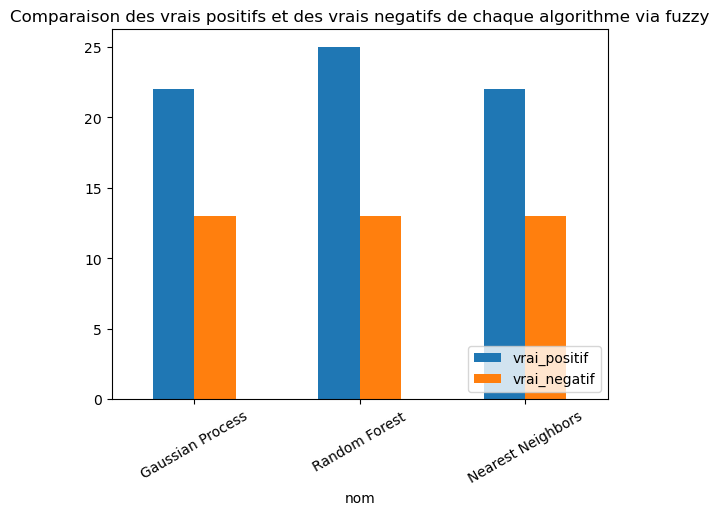

In [134]:
for title, predictions in liste_predictions_all:
	noms = []
	vrai_positif = []
	vrai_negatif = []
	for nom, _, y_pred_test in predictions:
		labels = np.unique(df_prepro[class_name].values)
		conf_matrix = confusion_matrix(y_test_sans_feature_select, y_pred_test, labels=labels)

		noms.append(nom)
		vrai_positif.append(conf_matrix[0][0])
		vrai_negatif.append(conf_matrix[1][1])

	data = {"nom": noms, "vrai_positif": vrai_positif, "vrai_negatif": vrai_negatif}
	df_matric_confu = pd.DataFrame(data, columns=["nom", "vrai_positif", "vrai_negatif"])
	df_matric_confu.plot.bar(x="nom", rot=30, title=f"Comparaison des vrais positifs et des vrais negatifs de chaque algorithme via {title}")
	plt.legend(loc="lower right")
	plt.savefig(f"{OUT_IMG}comparaison/matrice_confusion_{title}.png", bbox_inches='tight')
	plt.show()

#### Affichage des *ROC curves*.

Comparaison des *ROC curves* des modèles par méthodes.

In [152]:
X_tests = [
	X_test_sans_feature_select,
	X_test_reduct,
	X_test_quickreduct,
	X_test_variance,
	X_test_fuzzy
]

y_tests = [
	y_test_sans_feature_select,
	y_test_reduct,
	y_test_quickreduct,
	y_test_variance,
	y_test_fuzzy
]

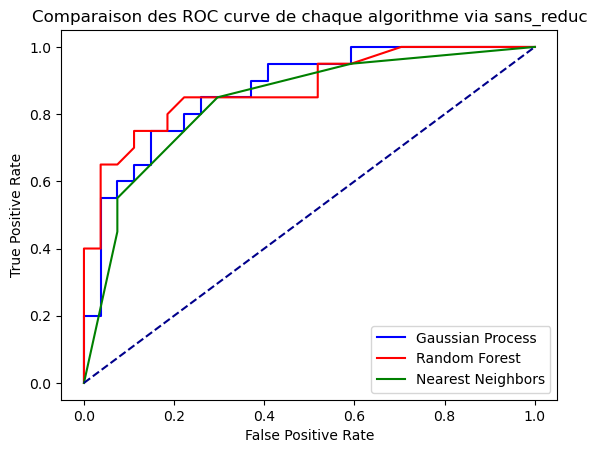

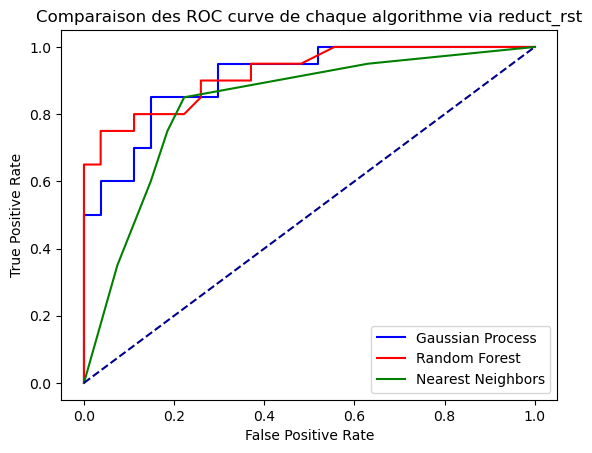

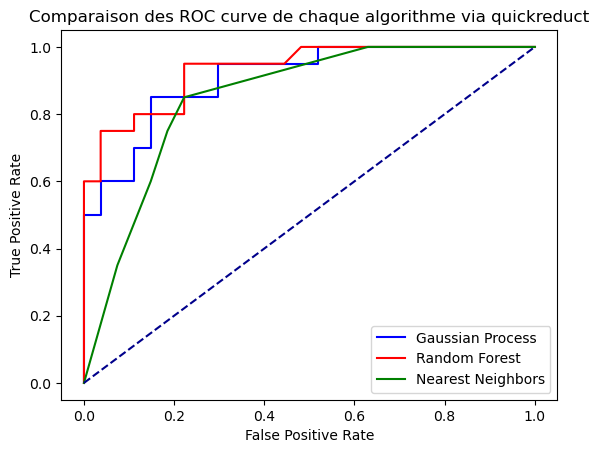

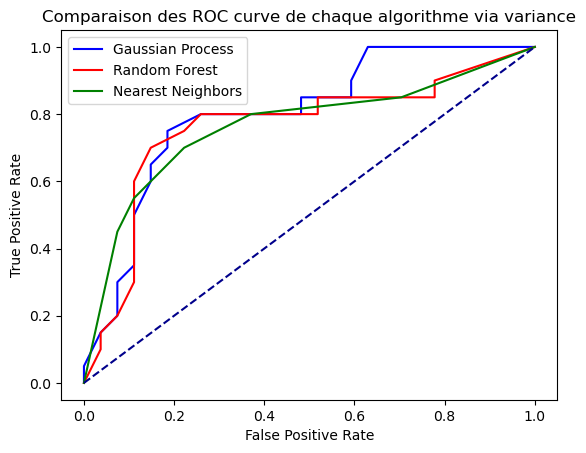

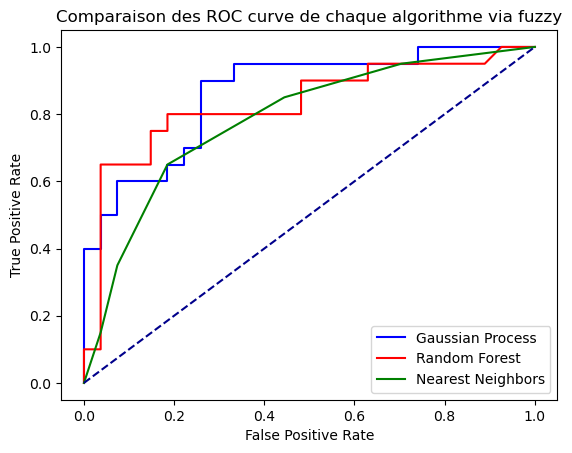

In [157]:
colors = ["blue", "red", "green"]
for index, (title, predictions) in enumerate(liste_predictions_all):
	for index2, (nom, model_fit, _) in enumerate(predictions):
		probs = model_fit.predict_proba(X_tests[index]) 
		probs = probs[:, 1]
		fper, tper, thresholds = roc_curve(y_tests[index], probs) 
		plt.plot(fper, tper, color=colors[index2], label=f"{nom}")

	plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title(f"Comparaison des ROC curve de chaque algorithme via {title}")
	plt.legend()
	plt.savefig(f"{OUT_IMG}comparaison/roc_curve_{title}.png", bbox_inches='tight')
	plt.show()

Comparaison des *ROC curves* des meilleurs modèles pour chaque méthodes.

In [162]:
liste_predictions_random_forest = []
for title, predictions in liste_predictions_all:
	for nom, model_fit, _ in predictions:
		if nom == "Random Forest":
			liste_predictions_random_forest.append((model_fit, title))

liste_predictions_random_forest

[(RandomForestClassifier(), 'sans_reduc'),
 (RandomForestClassifier(), 'reduct_rst'),
 (RandomForestClassifier(), 'quickreduct'),
 (RandomForestClassifier(), 'variance'),
 (RandomForestClassifier(), 'fuzzy')]

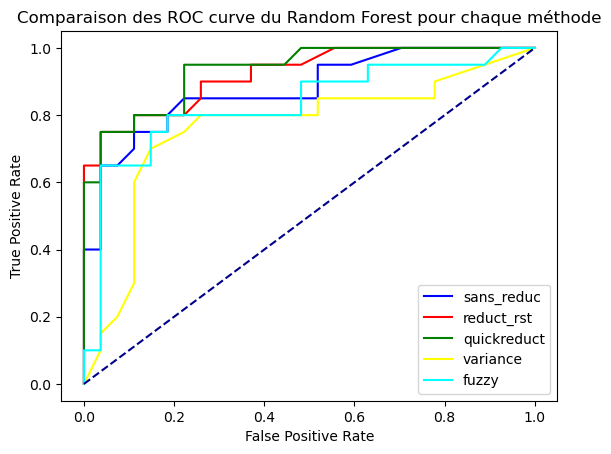

In [169]:
colors2 = colors + ["yellow", "cyan"]
for index, (model_fit, title) in enumerate(liste_predictions_random_forest):
	probs = model_fit.predict_proba(X_tests[index]) 
	probs = probs[:, 1]
	fper, tper, thresholds = roc_curve(y_tests[index], probs) 
	plt.plot(fper, tper, color=colors2[index], label=f"{title}")

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Comparaison des ROC curve du Random Forest pour chaque méthode")
plt.legend()
plt.savefig(f"{OUT_IMG}comparaison/roc_curve_Random_Forest_par_methode.png", bbox_inches='tight')
plt.show()

## Amélioration.

In [139]:
param_grid = { 
    'n_estimators': [150, 200, 250, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

trainset = [
    (X_train_sans_feature_select, y_train_sans_feature_select),
    (X_train_reduct, y_train_reduct),
    (X_train_quickreduct, y_train_quickreduct),
    (X_train_variance, y_train_variance),
    (X_train_fuzzy, y_train_fuzzy)
]

best_estimators = []
for x_trains, y_trains in trainset:
    rfc = RandomForestClassifier(random_state=RANDOM_STATE)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_trains, y_trains)
    best_estimators.append(CV_rfc.best_estimator_)

Affichage des meilleurs modèles.

In [140]:
for best_estimator in best_estimators:
	print(best_estimator)

RandomForestClassifier(max_depth=4, n_estimators=150, random_state=42)
RandomForestClassifier(max_depth=4, n_estimators=250, random_state=42)
RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
RandomForestClassifier(max_depth=7, n_estimators=150, random_state=42)
RandomForestClassifier(max_depth=4, n_estimators=250, random_state=42)


Entrainement des modèles et calculs de leur précision.

In [141]:
testset = [
    (X_test_sans_feature_select, y_test_sans_feature_select),
    (X_test_reduct, y_test_reduct),
    (X_test_quickreduct, y_test_quickreduct),
    (X_test_variance, y_test_variance),
    (X_test_fuzzy, y_test_fuzzy)
]

accs_upgrade = []
for index, (x_trains, y_trains) in enumerate(trainset):
    rfc = best_estimators[index]
    rfc.fit(x_trains, y_trains)
    pred = rfc.predict(testset[index][0])
    acc = accuracy_score(testset[index][1], pred)
    accs_upgrade.append(acc)

Construction de la listes de précisions pour les modèles sans et avec amélioration, avec et sans *feature selection*.

In [142]:
data_upgrade = [[type, acc, acc_upgrade] for type, acc, acc_upgrade in zip(types, df_acc["Random Forest"], accs_upgrade)]
data_upgrade

[['sans_feature', 0.7872340425531915, 0.8297872340425532],
 ['reduct_rst', 0.851063829787234, 0.8936170212765957],
 ['quickreduct', 0.851063829787234, 0.8723404255319149],
 ['variance', 0.7659574468085106, 0.7659574468085106],
 ['fuzzy', 0.8085106382978723, 0.8085106382978723]]

Construction du dataframe.

In [145]:
df_acc_upgrade = pd.DataFrame(data_upgrade, columns=["type", "Random Forest", "Random Forest Upgrade"])
df_acc_upgrade.set_index("type", inplace=True)
df_acc_upgrade

,Random Forest,Random Forest Upgrade
type,,
sans_feature,0.79,0.83
reduct_rst,0.85,0.89
quickreduct,0.85,0.87
variance,0.77,0.77
fuzzy,0.81,0.81


Affichage des précisions.

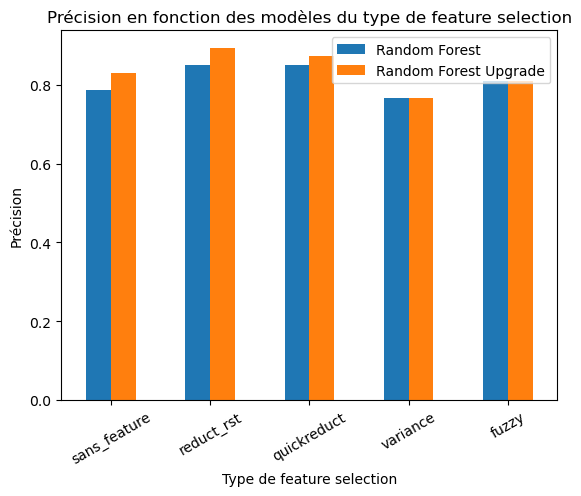

In [149]:
df_acc_upgrade.plot.bar()
plt.xlabel("Type de feature selection")
plt.xticks(rotation=30)
plt.ylabel("Précision")
plt.title("Précision en fonction des modèles du type de feature selection")
plt.savefig(f"{OUT_IMG}comparaison/accuracy_upgrade.png", bbox_inches='tight')
plt.show()

Nous avons réussi à améliorer les précisions des modèles pour les méthodes *sans feature selection*, *reduct_rst* et *quickreduct* mais pas pour les méthodes *virance threshold* et *fuzzy*.